In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import os
from scipy import stats
import re
import itertools
import nilearn as nil
from nilearn.plotting import plot_stat_map, plot_glass_brain, show
cwd=os.getcwd()
#file_list=['depression_tensor_masked.ica/report/t%s.txt'%(IC) for IC in range(1,52)]
#img_list=['depression_tensor_masked.ica/stats/thresh_zstat%s.nii.gz'%(i) for i in range(1,52)]
file_list=['second_go_w_contrast.ica/report/t%s.txt'%(IC) for IC in range(1,52)]
img_list=['second_go_w_contrast.ica/stats/thresh_zstat%s.nii.gz'%(i) for i in range(1,52)]
#file_list=['tensor_unordered.ica/report/t%s.txt'%(IC) for IC in range(1,52)]
#img_list=['tensor_unordered.ica/stats/thresh_zstat%s.nii.gz'%(i) for i in range(1,52)]
images=nil.image.load_img(img_list)



/usr/local/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  if __name__ == '__main__':
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/utils/graph.py:15: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .graph_shortest_path import graph_shortest_path  # noqa
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils.seq_dataset import ArrayDat

In [2]:
#These are the ID's and associated groups
group_id=pd.read_csv('Book1.csv')[['ID','Group']]
# These are the files that went into the ICA in the correct order
sub_list=pd.read_csv('Ordered_zimages/tica_filenames.txt',header=None)
order=[]
for i in range(len(sub_list[0])):
    order.append(re.search(r'sub-(.*)_smooth',sub_list[0][i]).group(1))
order=np.repeat(order,100)
print len(order)
print len(np.concatenate(np.genfromtxt(file_list[0])[:,:-2]))

14000
14000


In [3]:

#rew_cond=['LL' for _ in range(20)]+['SL' for _ in range(20)]+['Neu' for _ in range(20)]+['SG' for _ in range(20)]+['LG' for z in range(20)]
rew_cond=[-2 for _ in range(20)]+[-1 for _ in range(20)]+[0 for _ in range(20)]+[1 for _ in range(20)]+[2 for z in range(20)]

print rew_cond

list_of_dfs = [pd.DataFrame({'val%s'%(i+1):np.concatenate(np.genfromtxt(file_list[i])[:,:-2])})
                            for i in range(len(file_list))]
full_df=pd.concat(list_of_dfs,ignore_index=False,axis=1)
#full_df=full_df[(np.abs(stats.zscore(full_df))<3).all(axis=1)]
#print(np.abs(stats.zscore(full_df))<3).all(axis=1)
full_df['sub']=pd.Series(order)
full_df['re_cond']=pd.Series(list(rew_cond)*140)
full_df.re_cond.astype("category",ordered=True,categories=["LL","SL","Neu","SG","LG"])

result=pd.merge(full_df,group_id,left_on='sub',right_on='ID')


[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


In [4]:
# deal with outliers now that we have a full rank matrix 
Q1=result.quantile(0.25)
Q3=result.quantile(0.75)
IQR=Q3-Q1
lower=Q1-1.5*IQR
upper=Q3+1.5*IQR


#for i in range(1,52):
    #dep_val="val%s"%(i)
    #res_no_out=result.loc[(result[dep_val]>lower[dep_val])&(result[dep_val]<upper[dep_val])]


filter_col=[col for col in result if col.startswith('val')]
#z_b=pd.DataFrame(stats.zscore(result[filter_col]))
#z_a=pd.DataFrame(stats.zscore(res_no_out[filter_col]))

from scipy import stats
res_no_out=result[(np.abs(stats.zscore(result[filter_col])) < 3).all(axis=1)]

In [5]:
g1=result.groupby(['sub','re_cond'],as_index=False).mean()
import statsmodels.api as sm
import statsmodels
import statsmodels.formula.api as smf
from patsy.contrasts import Poly


/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/statespace/tools.py:59: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import (_representation, _kalman_filter, _kalman_smoother,
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:33: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import kalman_loglike
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:29: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from statsmodels.tsa.regime_switching._hamilton_filter import (


val1


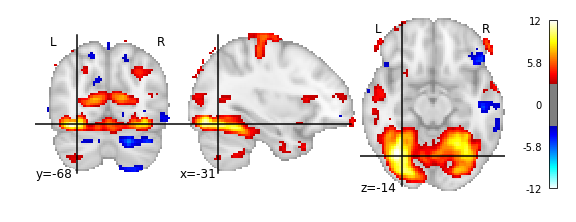

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

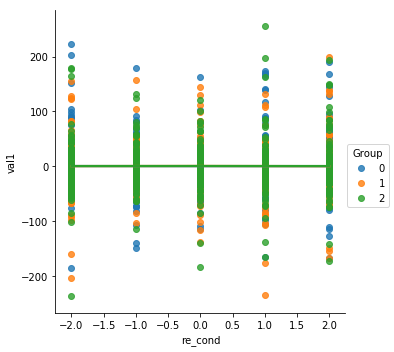

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val1       
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  441.7791   
Min. group size:      43          Likelihood:             -36594.4043
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.438    0.245  1.783 0.075 -0.044  0.919
C(re_cond, Poly).Linear     0.191    0.521  0.368 0.713 -0.829  1.212
C(re_cond, Poly).Quadratic  0.230    0.520  0.443 0.658 -0.789  1.249
C(re_cond, Poly).Cubic      0.054    0.519  0.105 0.917 -0.963  1.071
C(re_cond, Poly)^4         -0.076   

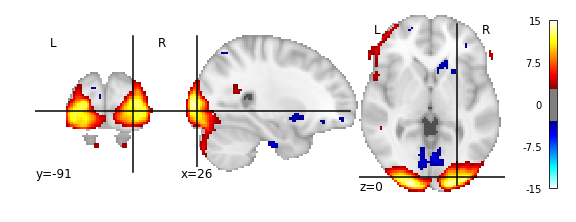

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

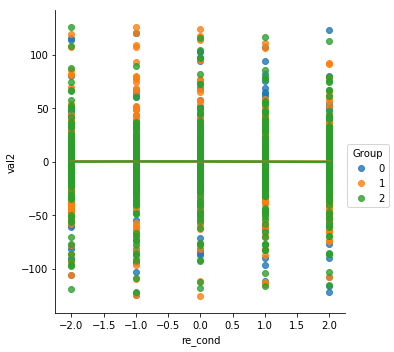

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val2       
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  323.8187   
Min. group size:      43          Likelihood:             -35322.3686
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.429    0.210 -2.038 0.042 -0.841 -0.016
C(re_cond, Poly).Linear    -0.419    0.446 -0.939 0.348 -1.293  0.455
C(re_cond, Poly).Quadratic -0.475    0.445 -1.067 0.286 -1.347  0.397
C(re_cond, Poly).Cubic     -0.167    0.444 -0.376 0.707 -1.038  0.704
C(re_cond, Poly)^4          0.625   

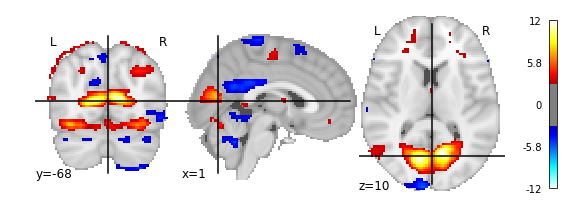

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

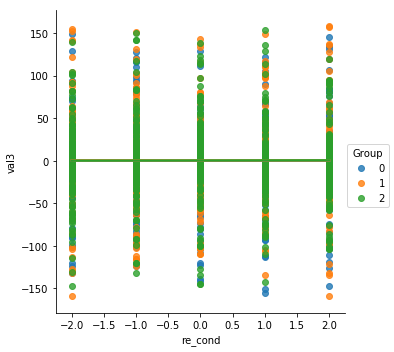

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val3       
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  563.8627   
Min. group size:      43          Likelihood:             -37592.6490
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.179    0.275 -0.649 0.516 -0.718  0.361
C(re_cond, Poly).Linear    -0.487    0.588 -0.828 0.407 -1.641  0.666
C(re_cond, Poly).Quadratic  0.233    0.587  0.396 0.692 -0.918  1.384
C(re_cond, Poly).Cubic      0.247    0.586  0.421 0.674 -0.902  1.396
C(re_cond, Poly)^4          0.017   

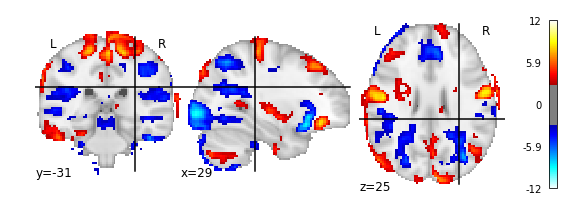

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

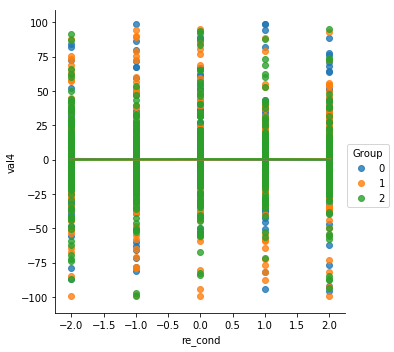

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val4       
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  207.4190   
Min. group size:      43          Likelihood:             -33499.6975
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.027    0.170 -0.159 0.873 -0.361  0.307
C(re_cond, Poly).Linear     0.215    0.357  0.603 0.546 -0.484  0.915
C(re_cond, Poly).Quadratic  0.128    0.356  0.359 0.720 -0.570  0.826
C(re_cond, Poly).Cubic     -0.146    0.356 -0.409 0.682 -0.842  0.551
C(re_cond, Poly)^4          0.517   

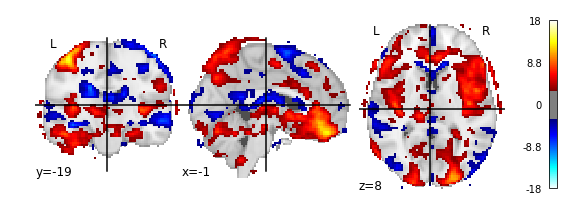

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

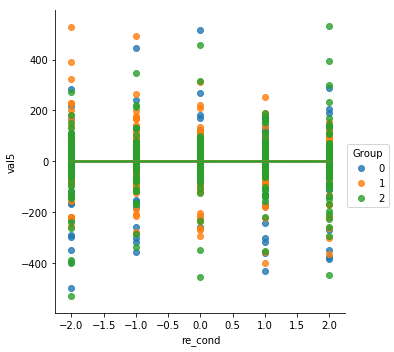

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val5       
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  1717.7395  
Min. group size:      43          Likelihood:             -42156.2901
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.137    0.485 -0.282 0.778 -1.088  0.814
C(re_cond, Poly).Linear     0.115    1.027  0.112 0.911 -1.898  2.128
C(re_cond, Poly).Quadratic -0.763    1.025 -0.745 0.456 -2.772  1.246
C(re_cond, Poly).Cubic      0.527    1.023  0.515 0.607 -1.478  2.532
C(re_cond, Poly)^4          0.953   

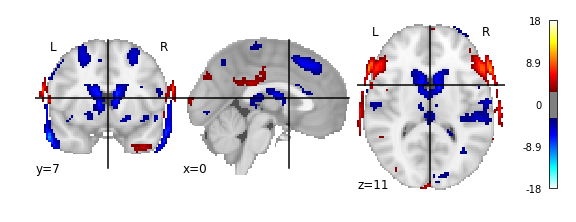

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

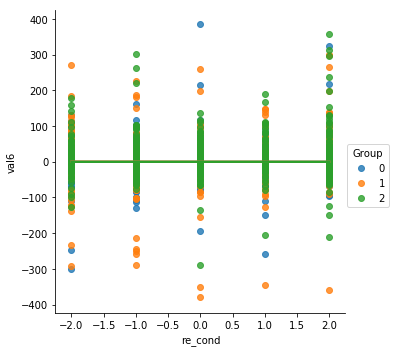

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val6       
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  751.2878   
Min. group size:      43          Likelihood:             -38769.9274
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.715    0.322  2.219 0.026  0.083  1.346
C(re_cond, Poly).Linear     1.065    0.679  1.567 0.117 -0.267  2.396
C(re_cond, Poly).Quadratic  0.677    0.678  0.998 0.318 -0.652  2.005
C(re_cond, Poly).Cubic     -0.456    0.677 -0.673 0.501 -1.782  0.871
C(re_cond, Poly)^4          0.404   

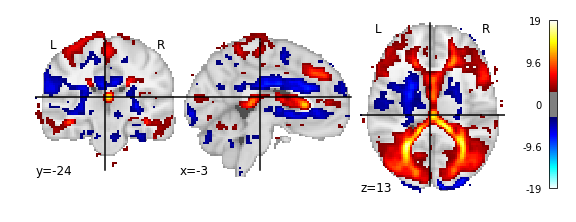

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

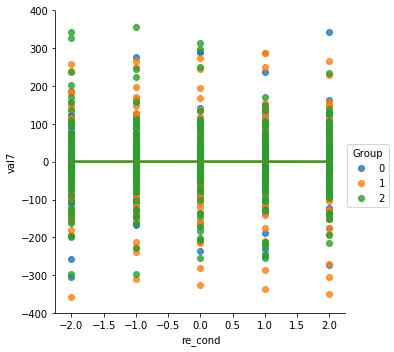

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     val7       
No. Observations:       8196        Method:                 REML       
No. Groups:             140         Scale:                  1205.9204  
Min. group size:        43          Likelihood:             -40983.1527
Max. group size:        71          Converged:              No         
Mean group size:        58.5                                           
-----------------------------------------------------------------------
                            Coef.   Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    -0.240    2.960 -0.081 0.935 -6.042  5.561
C(re_cond, Poly).Linear       0.001    0.863  0.001 0.999 -1.690  1.691
C(re_cond, Poly).Quadratic   -0.082    0.861 -0.095 0.924 -1.768  1.605
C(re_cond, Poly).Cubic        0.615    0.859  0.715 0.474 -1.069  2.299
C(re_cond

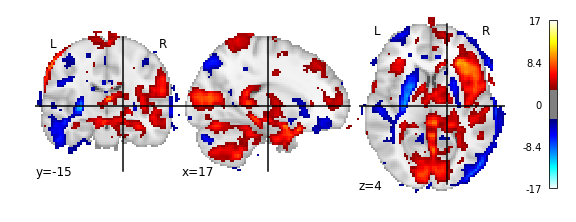

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

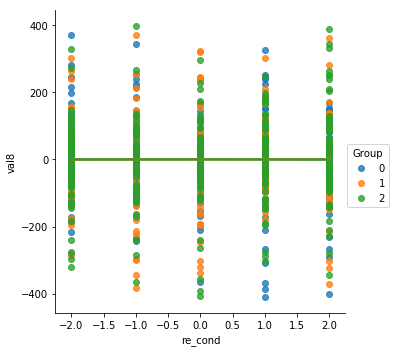

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val8       
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  1850.9080  
Min. group size:      43          Likelihood:             -42462.8672
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.354    0.507 -0.699 0.485 -1.347  0.639
C(re_cond, Poly).Linear    -0.434    1.066 -0.407 0.684 -2.524  1.656
C(re_cond, Poly).Quadratic -0.028    1.064 -0.027 0.979 -2.114  2.057
C(re_cond, Poly).Cubic     -0.334    1.062 -0.314 0.754 -2.416  1.748
C(re_cond, Poly)^4         -1.742   

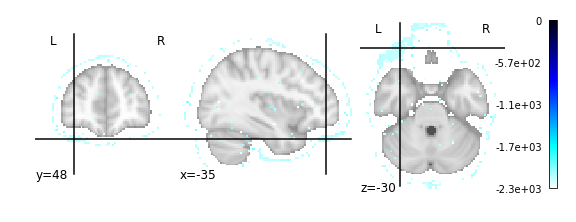

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

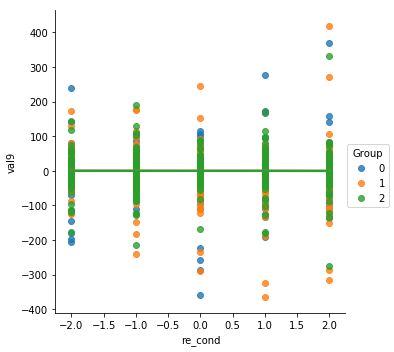

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val9       
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  599.3492   
Min. group size:      43          Likelihood:             -37843.4281
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.547    0.285 -1.918 0.055 -1.107  0.012
C(re_cond, Poly).Linear    -0.237    0.607 -0.390 0.697 -1.426  0.952
C(re_cond, Poly).Quadratic  0.246    0.605  0.406 0.685 -0.941  1.432
C(re_cond, Poly).Cubic      0.111    0.604  0.183 0.855 -1.074  1.295
C(re_cond, Poly)^4         -0.567   

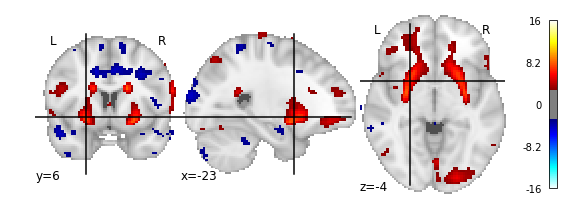

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

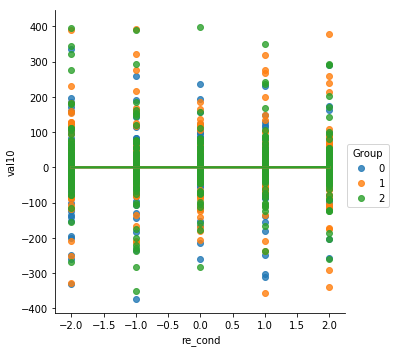

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val10      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  1188.3706  
Min. group size:      43          Likelihood:             -40647.6434
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.569    0.404  1.408 0.159 -0.223  1.362
C(re_cond, Poly).Linear    -0.657    0.854 -0.769 0.442 -2.331  1.018
C(re_cond, Poly).Quadratic  0.530    0.853  0.622 0.534 -1.140  2.201
C(re_cond, Poly).Cubic      0.242    0.851  0.284 0.776 -1.426  1.910
C(re_cond, Poly)^4         -0.293   

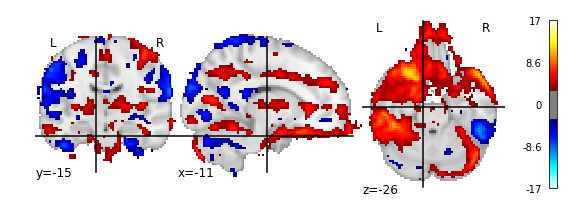

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

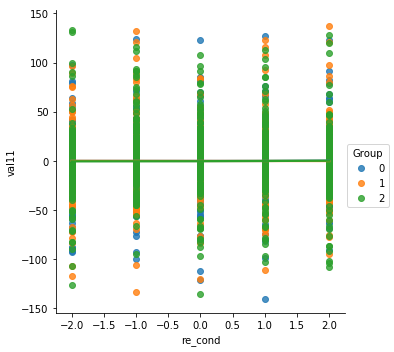

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val11      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  313.6189   
Min. group size:      43          Likelihood:             -35189.8093
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.168    0.205  0.821 0.412 -0.233  0.570
C(re_cond, Poly).Linear     0.073    0.439  0.166 0.868 -0.787  0.933
C(re_cond, Poly).Quadratic -0.481    0.438 -1.099 0.272 -1.340  0.377
C(re_cond, Poly).Cubic      0.452    0.437  1.034 0.301 -0.405  1.309
C(re_cond, Poly)^4         -0.454   

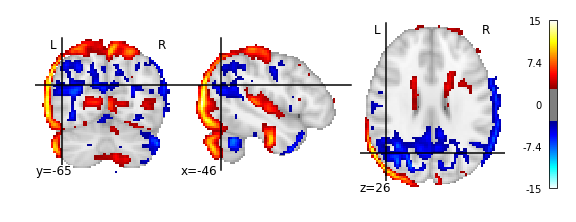

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

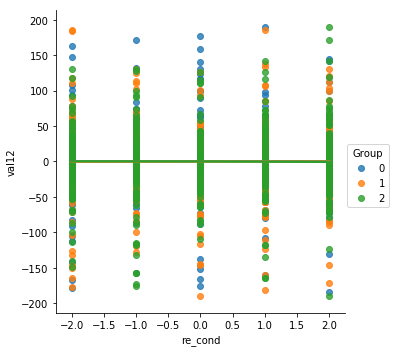

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val12      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  525.8228   
Min. group size:      43          Likelihood:             -37308.5280
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.151    0.269 -0.560 0.576 -0.679  0.377
C(re_cond, Poly).Linear     0.607    0.568  1.069 0.285 -0.507  1.721
C(re_cond, Poly).Quadratic -0.387    0.567 -0.682 0.495 -1.498  0.725
C(re_cond, Poly).Cubic      0.477    0.566  0.843 0.399 -0.633  1.587
C(re_cond, Poly)^4         -0.323   

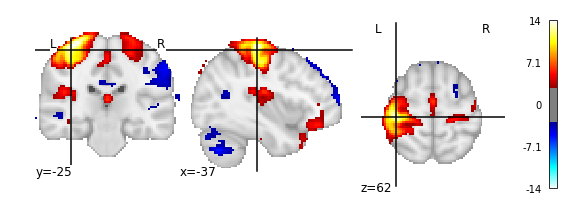

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

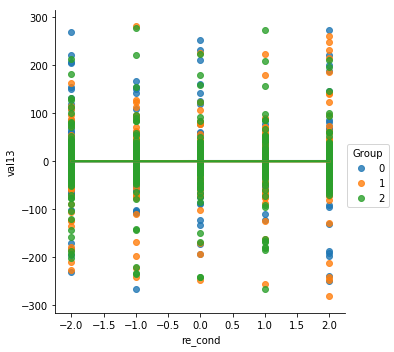

               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    val13      
No. Observations:     8196       Method:                REML       
No. Groups:           140        Scale:                 761.1535   
Min. group size:      43         Likelihood:            -38823.8877
Max. group size:      71         Converged:             No         
Mean group size:      58.5                                         
-------------------------------------------------------------------
                           Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                  0.093    0.326 0.285 0.776 -0.545  0.731
C(re_cond, Poly).Linear    0.602    0.684 0.880 0.379 -0.738  1.942
C(re_cond, Poly).Quadratic 0.141    0.682 0.207 0.836 -1.196  1.478
C(re_cond, Poly).Cubic     0.527    0.681 0.774 0.439 -0.808  1.862
C(re_cond, Poly)^4         0.137    0.680 0.202 0.840 -1.195  1

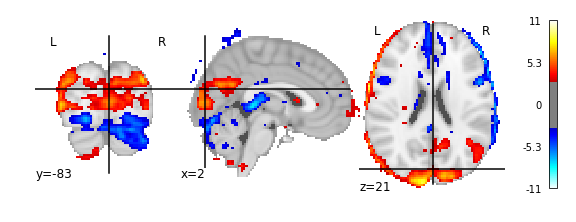

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

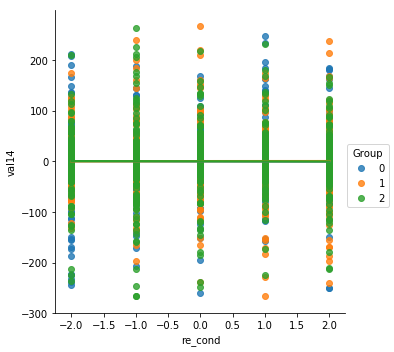

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val14      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  1061.1993  
Min. group size:      43          Likelihood:             -40185.6296
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.313    0.386  0.809 0.418 -0.445  1.070
C(re_cond, Poly).Linear     0.756    0.807  0.937 0.349 -0.826  2.338
C(re_cond, Poly).Quadratic -0.404    0.806 -0.502 0.616 -1.983  1.175
C(re_cond, Poly).Cubic     -0.568    0.804 -0.707 0.480 -2.145  1.008
C(re_cond, Poly)^4          0.023   

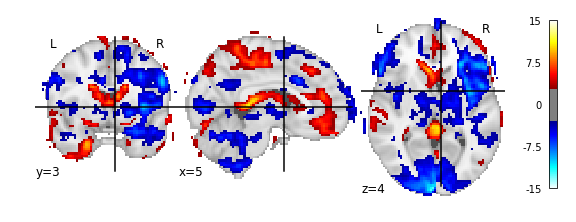

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

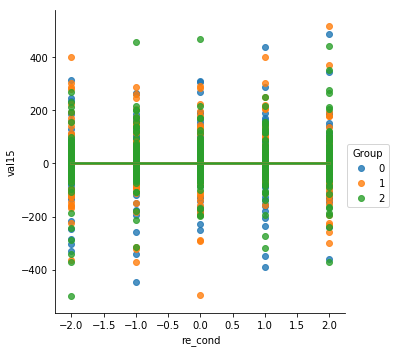

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val15      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  1779.6198  
Min. group size:      43          Likelihood:             -42300.4917
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.551    0.491  1.121 0.262 -0.412  1.514
C(re_cond, Poly).Linear     0.553    1.045  0.529 0.597 -1.496  2.601
C(re_cond, Poly).Quadratic -0.467    1.043 -0.447 0.655 -2.511  1.578
C(re_cond, Poly).Cubic     -0.156    1.042 -0.150 0.881 -2.198  1.885
C(re_cond, Poly)^4         -0.498   

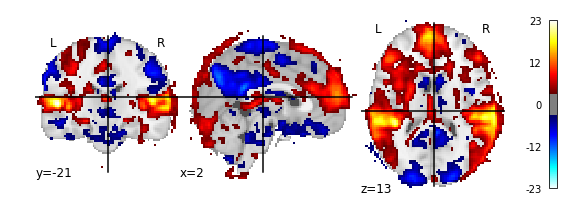

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

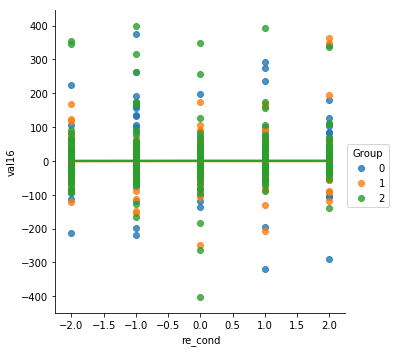

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val16      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  588.0251   
Min. group size:      43          Likelihood:             -37766.0484
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.329    0.284  1.158 0.247 -0.228  0.886
C(re_cond, Poly).Linear     0.461    0.601  0.767 0.443 -0.717  1.639
C(re_cond, Poly).Quadratic -0.147    0.600 -0.245 0.807 -1.322  1.029
C(re_cond, Poly).Cubic      0.597    0.599  0.997 0.319 -0.576  1.771
C(re_cond, Poly)^4         -0.995   

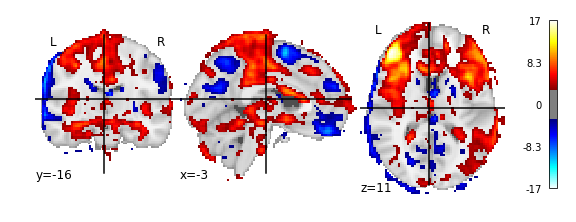

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

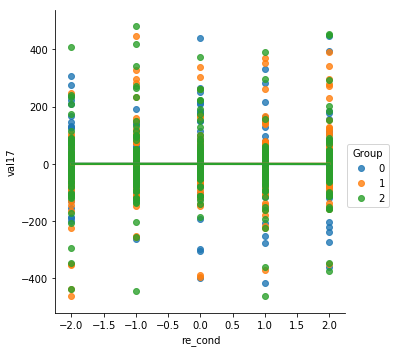

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val17      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  1730.3521  
Min. group size:      43          Likelihood:             -42187.3478
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.135    0.491  0.274 0.784 -0.828  1.097
C(re_cond, Poly).Linear     0.753    1.031  0.731 0.465 -1.267  2.774
C(re_cond, Poly).Quadratic -1.064    1.029 -1.034 0.301 -3.080  0.953
C(re_cond, Poly).Cubic      2.173    1.027  2.115 0.034  0.160  4.186
C(re_cond, Poly)^4          1.022   

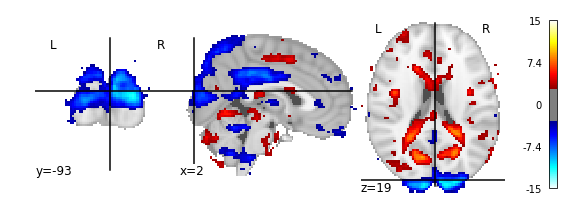

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

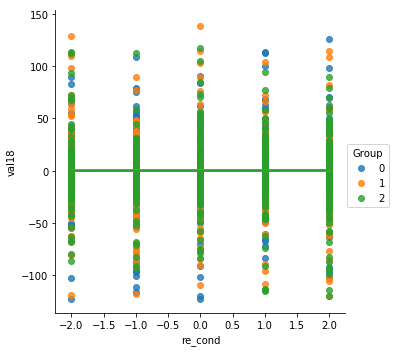

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val18      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  258.5343   
Min. group size:      43          Likelihood:             -34401.8134
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.261    0.190 -1.372 0.170 -0.633  0.112
C(re_cond, Poly).Linear    -0.264    0.399 -0.662 0.508 -1.045  0.517
C(re_cond, Poly).Quadratic -0.071    0.398 -0.178 0.858 -0.850  0.708
C(re_cond, Poly).Cubic     -0.448    0.397 -1.128 0.259 -1.226  0.330
C(re_cond, Poly)^4          0.037   

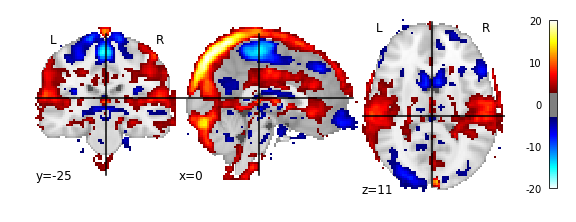

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

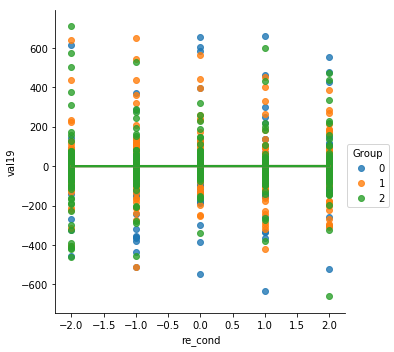

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val19      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  2809.6467  
Min. group size:      43          Likelihood:             -44172.4415
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.294    0.625 -0.470 0.638 -1.519  0.931
C(re_cond, Poly).Linear     0.456    1.314  0.347 0.728 -2.118  3.031
C(re_cond, Poly).Quadratic -1.109    1.311 -0.846 0.398 -3.678  1.460
C(re_cond, Poly).Cubic      0.148    1.309  0.113 0.910 -2.417  2.713
C(re_cond, Poly)^4          1.656   

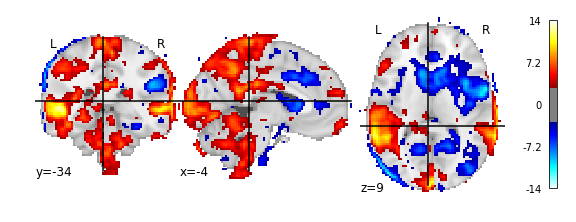

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

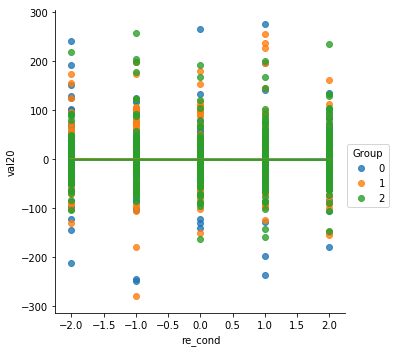

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val20      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  619.5033   
Min. group size:      43          Likelihood:             -37981.0697
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.006    0.295  0.019 0.985 -0.572  0.583
C(re_cond, Poly).Linear    -0.587    0.617 -0.951 0.341 -1.796  0.622
C(re_cond, Poly).Quadratic -0.222    0.616 -0.360 0.719 -1.428  0.985
C(re_cond, Poly).Cubic     -0.128    0.614 -0.209 0.834 -1.333  1.076
C(re_cond, Poly)^4         -0.862   

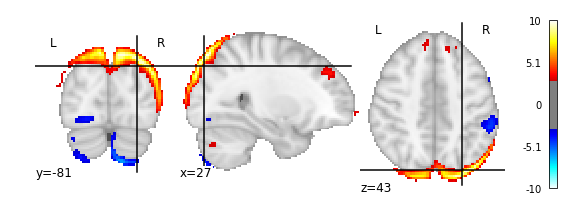

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

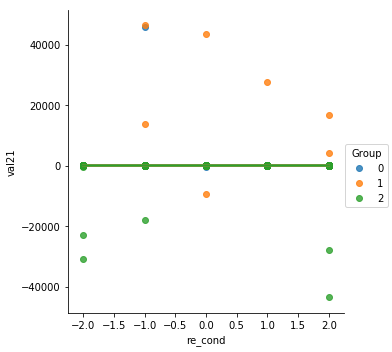

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      val21       
No. Observations:      8196         Method:                  REML        
No. Groups:            140          Scale:                   1455875.4251
Min. group size:       43           Likelihood:              -69771.2257 
Max. group size:       71           Converged:               No          
Mean group size:       58.5                                              
-------------------------------------------------------------------------
                            Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                     5.242   14.297  0.367 0.714  -22.779 33.263
C(re_cond, Poly).Linear      -9.421   29.901 -0.315 0.753  -68.027 49.184
C(re_cond, Poly).Quadratic  -63.524   29.841 -2.129 0.033 -122.012 -5.036
C(re_cond, Poly).Cubic       22.352   29.791  0.750 0.45

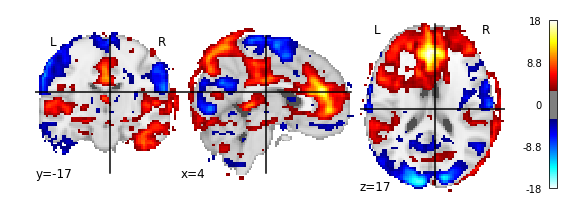

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

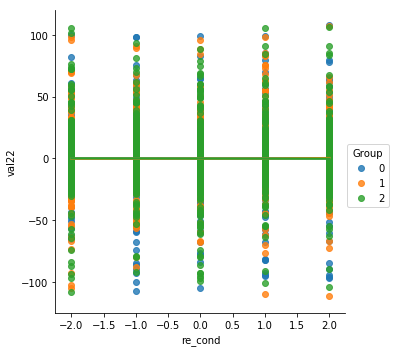

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val22      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  286.8289   
Min. group size:      43          Likelihood:             -34826.0039
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.200    0.199  1.006 0.314 -0.189  0.589
C(re_cond, Poly).Linear     0.192    0.420  0.458 0.647 -0.631  1.015
C(re_cond, Poly).Quadratic  0.188    0.419  0.449 0.653 -0.633  1.009
C(re_cond, Poly).Cubic      0.091    0.418  0.218 0.828 -0.729  0.910
C(re_cond, Poly)^4         -0.224   

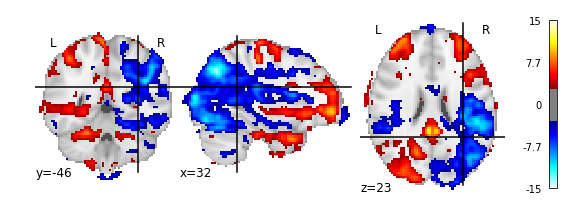

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

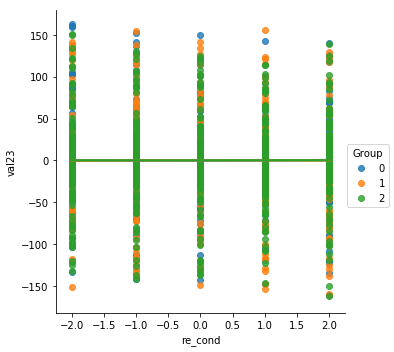

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val23      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  625.2623   
Min. group size:      43          Likelihood:             -38018.0361
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.018    0.294 -0.062 0.951 -0.595  0.558
C(re_cond, Poly).Linear    -0.687    0.620 -1.108 0.268 -1.901  0.528
C(re_cond, Poly).Quadratic  0.276    0.618  0.447 0.655 -0.936  1.488
C(re_cond, Poly).Cubic      0.036    0.617  0.059 0.953 -1.174  1.246
C(re_cond, Poly)^4          0.125   

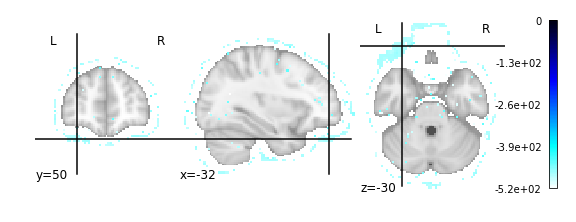

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

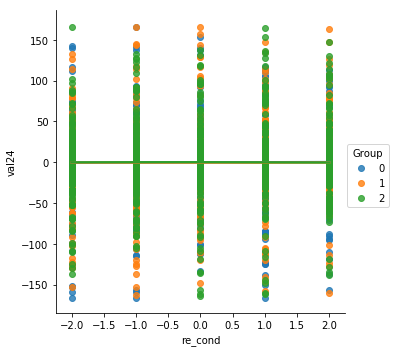

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val24      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  691.6054   
Min. group size:      43          Likelihood:             -38432.4277
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.143    0.312  0.458 0.647 -0.469  0.755
C(re_cond, Poly).Linear     1.497    0.652  2.297 0.022  0.219  2.774
C(re_cond, Poly).Quadratic -0.526    0.650 -0.809 0.419 -1.801  0.749
C(re_cond, Poly).Cubic      0.080    0.649  0.124 0.902 -1.192  1.353
C(re_cond, Poly)^4          0.226   

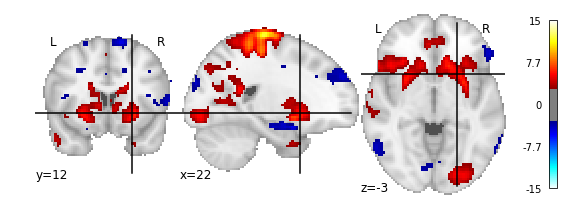

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

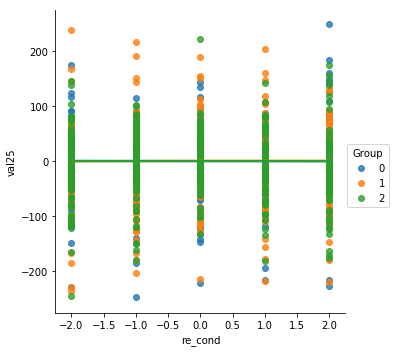

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val25      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  693.8660   
Min. group size:      43          Likelihood:             -38444.2056
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.764    0.309 -2.469 0.014 -1.370 -0.157
C(re_cond, Poly).Linear     0.270    0.653  0.414 0.679 -1.009  1.550
C(re_cond, Poly).Quadratic -0.479    0.651 -0.735 0.463 -1.755  0.798
C(re_cond, Poly).Cubic      0.522    0.650  0.802 0.422 -0.753  1.796
C(re_cond, Poly)^4          0.726   

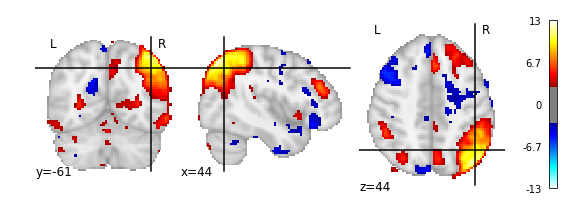

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

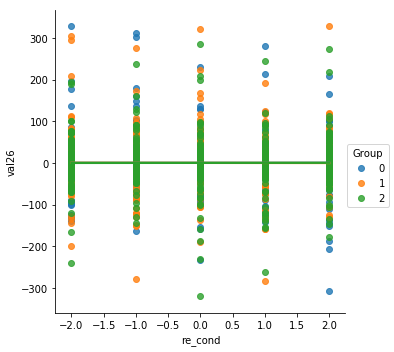

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val26      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  752.2178   
Min. group size:      43          Likelihood:             -38775.5834
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.241    0.324  0.744 0.457 -0.394  0.875
C(re_cond, Poly).Linear    -0.054    0.680 -0.079 0.937 -1.386  1.278
C(re_cond, Poly).Quadratic -0.202    0.678 -0.297 0.766 -1.531  1.128
C(re_cond, Poly).Cubic      0.644    0.677  0.951 0.342 -0.683  1.971
C(re_cond, Poly)^4          0.416   

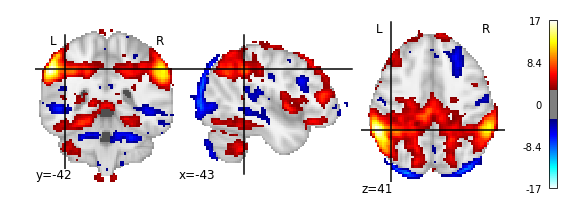

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

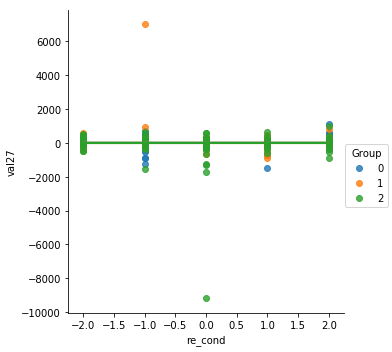

                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     val27      
No. Observations:      8196        Method:                 REML       
No. Groups:            140         Scale:                  21304.8817 
Min. group size:       43          Likelihood:             -52470.1824
Max. group size:       71          Converged:              No         
Mean group size:       58.5                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------
Intercept                   1.370    1.731  0.791 0.429  -2.022  4.761
C(re_cond, Poly).Linear     0.746    3.617  0.206 0.837  -6.343  7.836
C(re_cond, Poly).Quadratic  5.145    3.610  1.425 0.154  -1.931 12.221
C(re_cond, Poly).Cubic      3.883    3.604  1.077 0.281  -3.180 10.947
C(re_cond, Poly)^4    

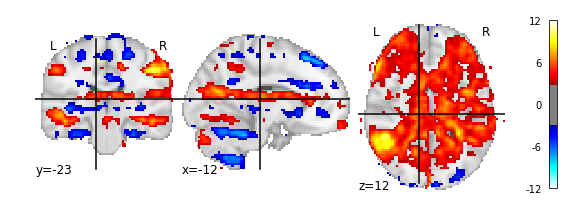

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

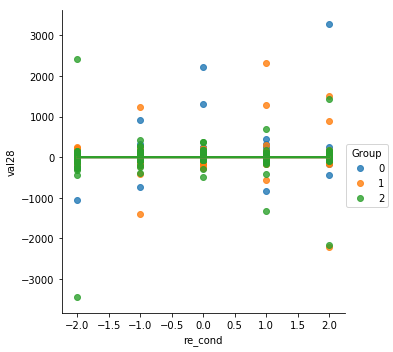

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val28      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  8896.2891  
Min. group size:      43          Likelihood:             -48892.6982
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.919    1.111  0.827 0.408 -1.259  3.097
C(re_cond, Poly).Linear     3.669    2.338  1.569 0.117 -0.913  8.251
C(re_cond, Poly).Quadratic -2.223    2.333 -0.953 0.341 -6.796  2.350
C(re_cond, Poly).Cubic      1.454    2.329  0.624 0.532 -3.111  6.019
C(re_cond, Poly)^4          0.195   

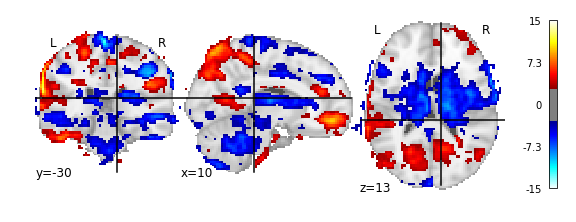

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

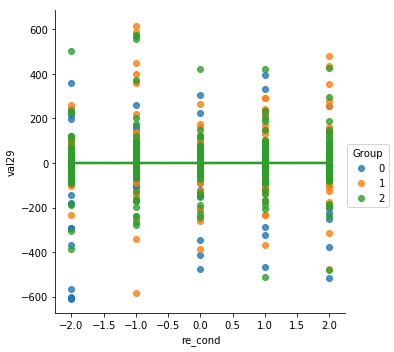

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val29      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  1907.9254  
Min. group size:      43          Likelihood:             -42587.1704
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.237    0.515 -0.460 0.645 -1.245  0.772
C(re_cond, Poly).Linear    -0.138    1.083 -0.128 0.899 -2.260  1.984
C(re_cond, Poly).Quadratic -0.582    1.080 -0.539 0.590 -2.699  1.535
C(re_cond, Poly).Cubic      1.532    1.078  1.421 0.155 -0.582  3.646
C(re_cond, Poly)^4         -1.891   

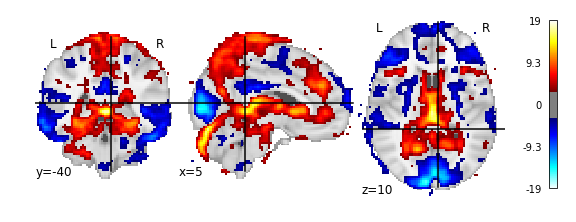

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

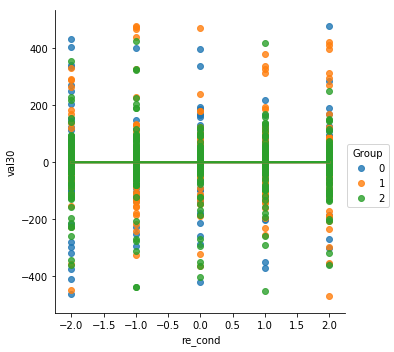

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val30      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  2027.2312  
Min. group size:      43          Likelihood:             -42834.8733
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.302    0.528 -0.573 0.567 -1.336  0.732
C(re_cond, Poly).Linear     0.279    1.116  0.250 0.803 -1.908  2.466
C(re_cond, Poly).Quadratic -0.804    1.113 -0.722 0.470 -2.987  1.378
C(re_cond, Poly).Cubic      0.323    1.112  0.291 0.771 -1.855  2.502
C(re_cond, Poly)^4         -1.225   

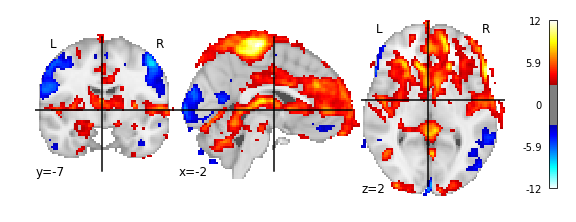

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

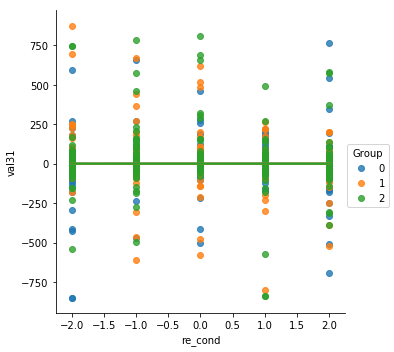

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val31      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  2838.6220  
Min. group size:      43          Likelihood:             -44214.1034
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.479    0.627  0.765 0.445 -0.749  1.707
C(re_cond, Poly).Linear    -1.312    1.321 -0.994 0.320 -3.900  1.276
C(re_cond, Poly).Quadratic -1.846    1.318 -1.401 0.161 -4.428  0.737
C(re_cond, Poly).Cubic      1.224    1.315  0.931 0.352 -1.354  3.802
C(re_cond, Poly)^4          2.003   

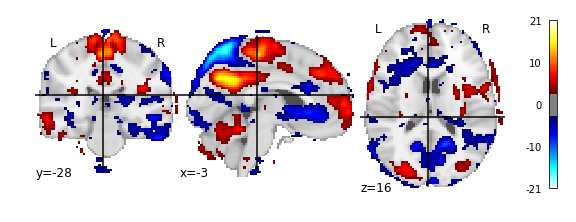

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

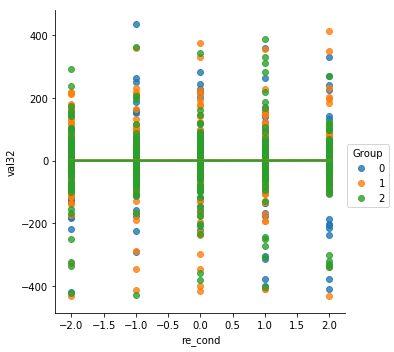

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val32      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  1816.1686  
Min. group size:      43          Likelihood:             -42385.3449
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.704    0.502 -1.403 0.161 -1.688  0.280
C(re_cond, Poly).Linear     0.607    1.056  0.575 0.565 -1.463  2.677
C(re_cond, Poly).Quadratic -0.576    1.054 -0.547 0.585 -2.642  1.490
C(re_cond, Poly).Cubic      1.142    1.052  1.085 0.278 -0.920  3.204
C(re_cond, Poly)^4         -1.003   

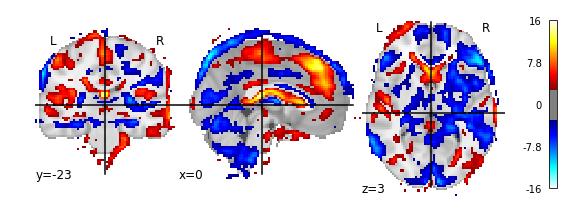

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

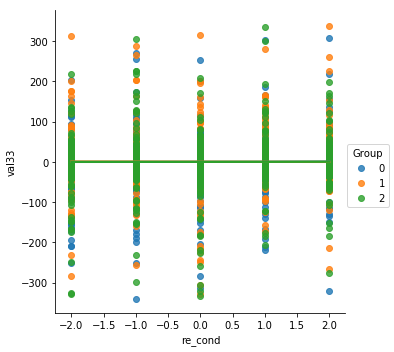

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val33      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  1210.3064  
Min. group size:      43          Likelihood:             -40723.8882
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.306    0.412 -0.743 0.457 -1.114  0.501
C(re_cond, Poly).Linear     1.534    0.862  1.779 0.075 -0.156  3.224
C(re_cond, Poly).Quadratic  1.431    0.860  1.663 0.096 -0.256  3.117
C(re_cond, Poly).Cubic      0.670    0.859  0.780 0.436 -1.014  2.353
C(re_cond, Poly)^4         -2.698   

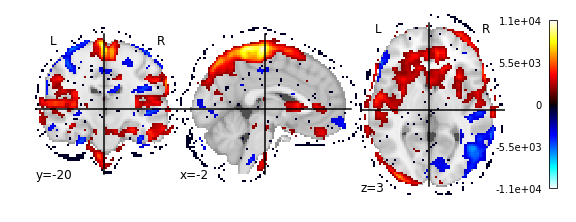

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

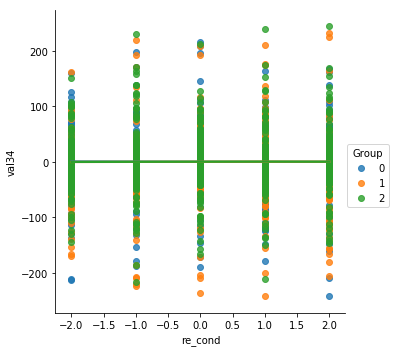

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val34      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  865.2860   
Min. group size:      43          Likelihood:             -39347.8271
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.714    0.344 -2.075 0.038 -1.388 -0.039
C(re_cond, Poly).Linear     0.307    0.729  0.422 0.673 -1.121  1.736
C(re_cond, Poly).Quadratic -0.882    0.727 -1.212 0.226 -2.307  0.544
C(re_cond, Poly).Cubic     -0.218    0.726 -0.300 0.764 -1.642  1.205
C(re_cond, Poly)^4          0.729   

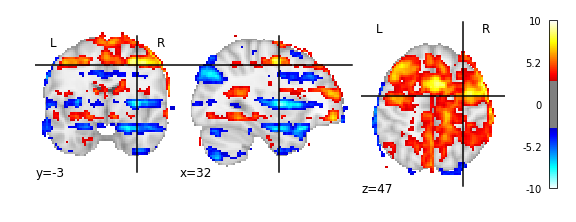

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

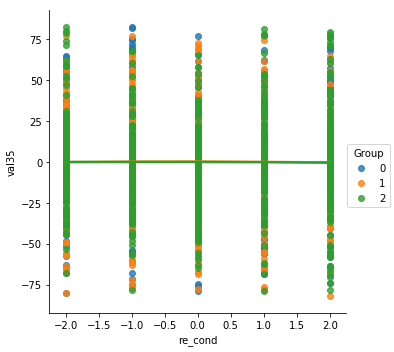

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val35      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  226.8557   
Min. group size:      43          Likelihood:             -33865.3935
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.102    0.177 -0.580 0.562 -0.449  0.244
C(re_cond, Poly).Linear    -0.242    0.373 -0.647 0.517 -0.973  0.490
C(re_cond, Poly).Quadratic  0.090    0.372  0.241 0.810 -0.640  0.820
C(re_cond, Poly).Cubic      0.065    0.372  0.174 0.862 -0.664  0.793
C(re_cond, Poly)^4         -0.030   

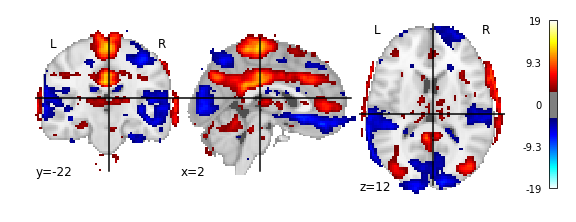

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

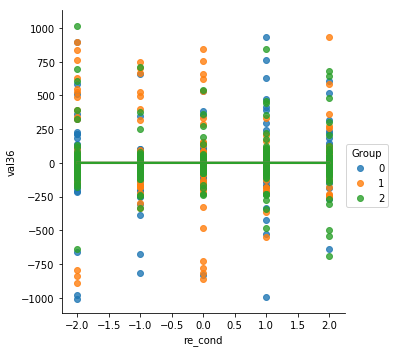

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val36      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  5104.9157  
Min. group size:      43          Likelihood:             -46618.3174
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.604    0.844  0.715 0.475 -1.051  2.258
C(re_cond, Poly).Linear    -0.707    1.771 -0.399 0.690 -4.177  2.764
C(re_cond, Poly).Quadratic  2.306    1.767  1.305 0.192 -1.158  5.769
C(re_cond, Poly).Cubic     -1.114    1.764 -0.632 0.528 -4.572  2.343
C(re_cond, Poly)^4         -0.159   

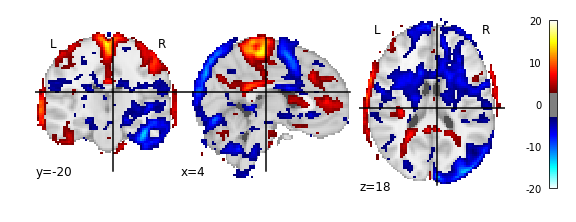

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

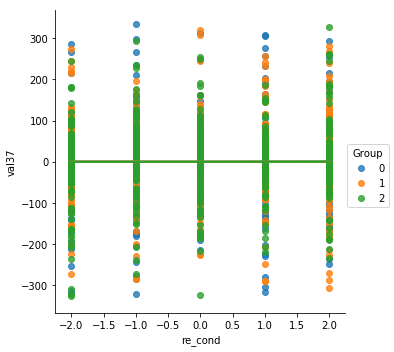

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val37      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  1761.9552  
Min. group size:      43          Likelihood:             -42260.8288
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.161    0.493  0.326 0.744 -0.806  1.127
C(re_cond, Poly).Linear     1.997    1.040  1.920 0.055 -0.041  4.036
C(re_cond, Poly).Quadratic -0.116    1.038 -0.112 0.911 -2.151  1.919
C(re_cond, Poly).Cubic      0.885    1.036  0.854 0.393 -1.146  2.917
C(re_cond, Poly)^4         -0.667   

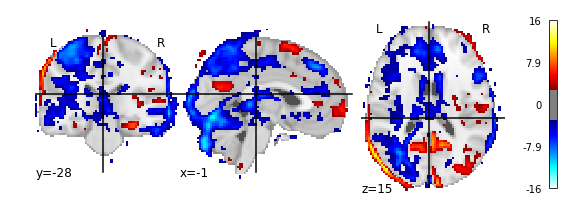

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

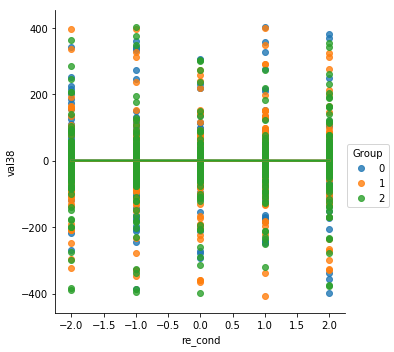

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val38      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  2135.8746  
Min. group size:      43          Likelihood:             -43049.9426
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.891    0.547 -1.631 0.103 -1.963  0.180
C(re_cond, Poly).Linear    -0.746    1.145 -0.651 0.515 -2.991  1.499
C(re_cond, Poly).Quadratic  0.825    1.143  0.722 0.470 -1.415  3.065
C(re_cond, Poly).Cubic     -0.060    1.141 -0.053 0.958 -2.296  2.176
C(re_cond, Poly)^4         -0.073   

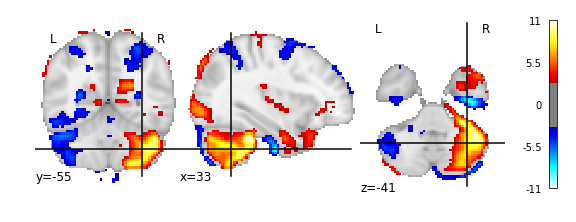

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

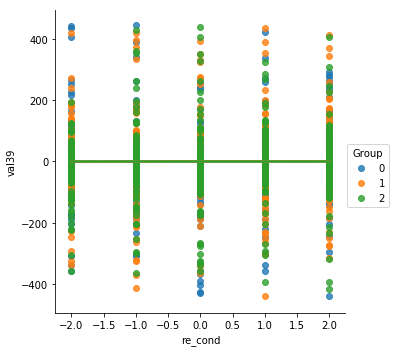

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val39      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  2719.2470  
Min. group size:      43          Likelihood:             -44037.1732
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.092    0.609 -0.151 0.880 -1.286  1.102
C(re_cond, Poly).Linear     1.283    1.292  0.993 0.321 -1.249  3.816
C(re_cond, Poly).Quadratic  1.013    1.290  0.786 0.432 -1.514  3.541
C(re_cond, Poly).Cubic      0.998    1.287  0.775 0.438 -1.526  3.521
C(re_cond, Poly)^4         -0.375   

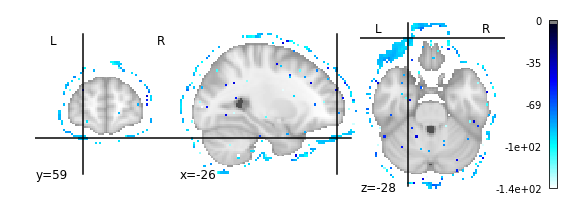

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

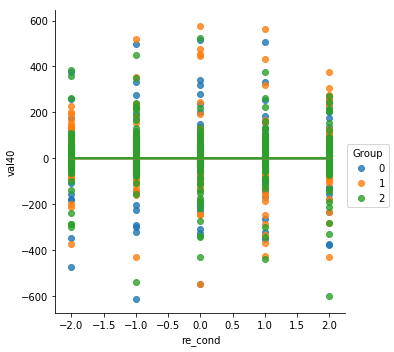

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val40      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  2147.0573  
Min. group size:      43          Likelihood:             -43071.1677
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.551    0.547  1.007 0.314 -0.522  1.624
C(re_cond, Poly).Linear    -0.636    1.148 -0.554 0.579 -2.887  1.614
C(re_cond, Poly).Quadratic -0.258    1.146 -0.225 0.822 -2.504  1.988
C(re_cond, Poly).Cubic      1.411    1.144  1.233 0.218 -0.832  3.653
C(re_cond, Poly)^4         -0.889   

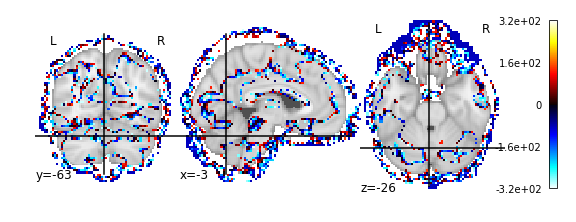

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

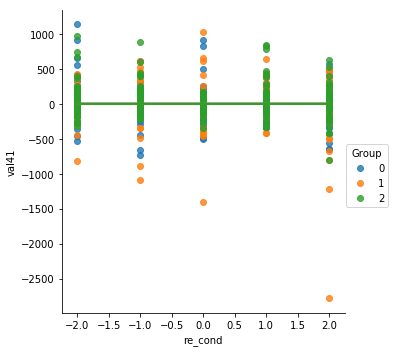

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val41      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  6886.8721  
Min. group size:      43          Likelihood:             -47843.8918
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.056    0.976  1.083 0.279 -0.856  2.969
C(re_cond, Poly).Linear    -4.024    2.056 -1.957 0.050 -8.055  0.006
C(re_cond, Poly).Quadratic -1.051    2.052 -0.512 0.609 -5.074  2.972
C(re_cond, Poly).Cubic     -3.388    2.049 -1.654 0.098 -7.403  0.628
C(re_cond, Poly)^4         -2.671   

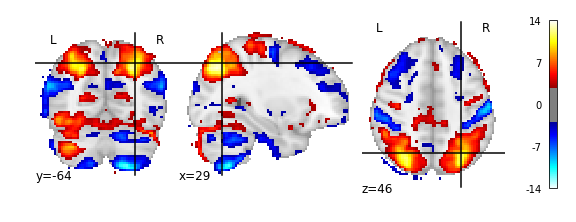

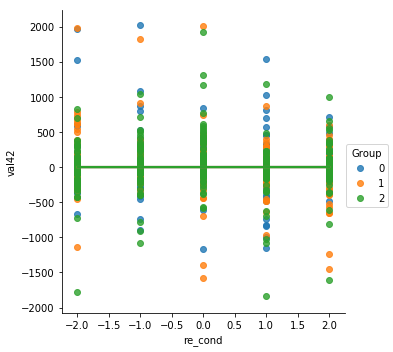

                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     val42      
No. Observations:      8196        Method:                 REML       
No. Groups:            140         Scale:                  14542.1535 
Min. group size:       43          Likelihood:             -50907.4133
Max. group size:       71          Converged:              Yes        
Mean group size:       58.5                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------
Intercept                   1.681    1.443  1.165 0.244  -1.146  4.509
C(re_cond, Poly).Linear    -4.938    2.989 -1.652 0.099 -10.796  0.920
C(re_cond, Poly).Quadratic -1.804    2.983 -0.605 0.545  -7.649  4.042
C(re_cond, Poly).Cubic      4.678    2.978  1.571 0.116  -1.158 10.514
C(re_cond, Poly)^4    

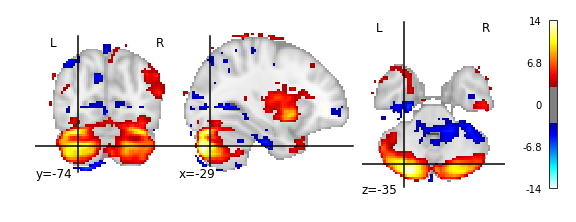

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

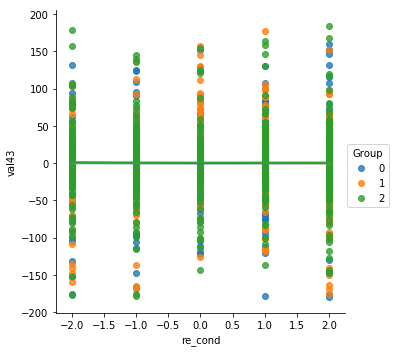

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val43      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  544.7148   
Min. group size:      43          Likelihood:             -37452.1515
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.048    0.272  0.176 0.860 -0.486  0.582
C(re_cond, Poly).Linear    -0.032    0.578 -0.056 0.956 -1.166  1.101
C(re_cond, Poly).Quadratic  0.075    0.577  0.129 0.897 -1.057  1.206
C(re_cond, Poly).Cubic     -0.703    0.576 -1.220 0.223 -1.832  0.426
C(re_cond, Poly)^4          0.714   

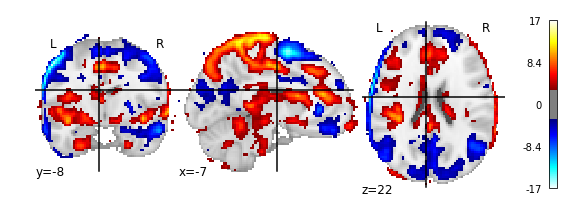

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

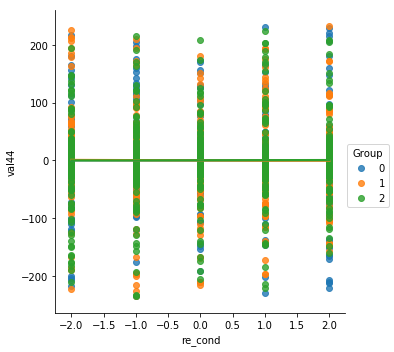

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val44      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  1053.4962  
Min. group size:      43          Likelihood:             -40154.4163
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.042    0.381 -0.111 0.911 -0.789  0.705
C(re_cond, Poly).Linear    -0.292    0.804 -0.362 0.717 -1.868  1.285
C(re_cond, Poly).Quadratic -0.283    0.803 -0.353 0.724 -1.856  1.290
C(re_cond, Poly).Cubic     -0.439    0.801 -0.548 0.584 -2.009  1.132
C(re_cond, Poly)^4         -1.248   

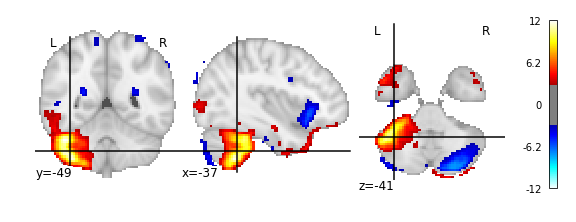

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

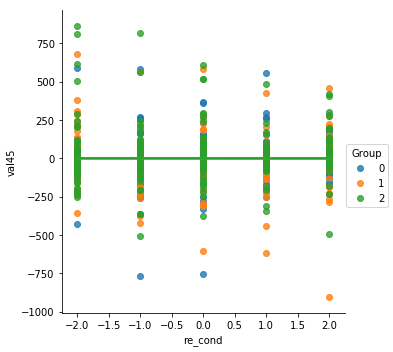

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val45      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  2592.2570  
Min. group size:      43          Likelihood:             -43841.7347
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.456    0.596  0.764 0.445 -0.713  1.625
C(re_cond, Poly).Linear    -1.784    1.262 -1.414 0.157 -4.257  0.689
C(re_cond, Poly).Quadratic  1.522    1.259  1.209 0.227 -0.946  3.990
C(re_cond, Poly).Cubic     -0.919    1.257 -0.731 0.465 -3.383  1.544
C(re_cond, Poly)^4          1.574   

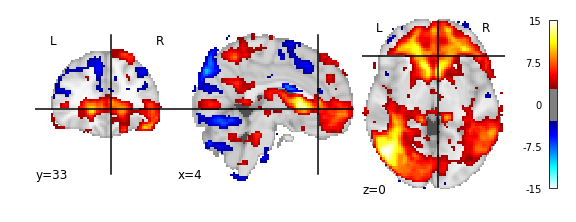

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

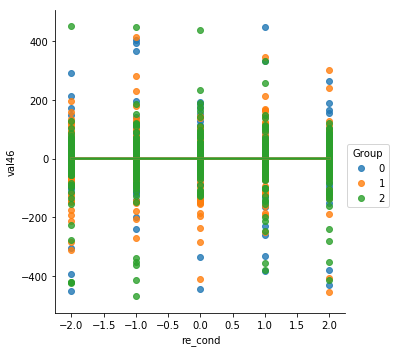

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val46      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  1596.9625  
Min. group size:      43          Likelihood:             -41858.9371
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.985    0.472 -2.086 0.037 -1.910 -0.059
C(re_cond, Poly).Linear    -0.129    0.990 -0.130 0.897 -2.070  1.812
C(re_cond, Poly).Quadratic -0.519    0.988 -0.525 0.600 -2.456  1.419
C(re_cond, Poly).Cubic      0.360    0.987  0.365 0.715 -1.574  2.293
C(re_cond, Poly)^4          0.261   

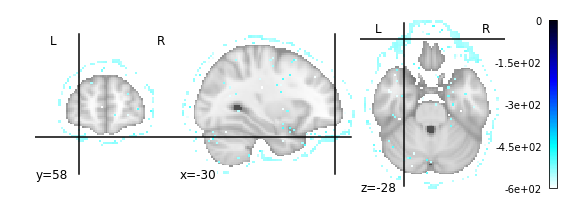

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

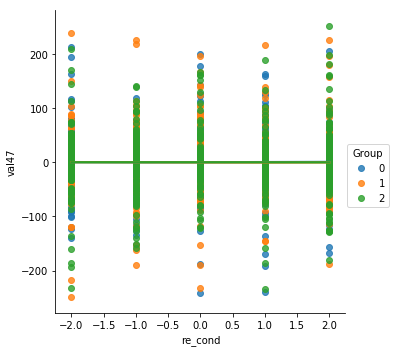

               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    val47      
No. Observations:     8196       Method:                REML       
No. Groups:           140        Scale:                 735.5933   
Min. group size:      43         Likelihood:            -38683.5939
Max. group size:      71         Converged:             No         
Mean group size:      58.5                                         
-------------------------------------------------------------------
                           Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                  0.119    0.319 0.373 0.709 -0.506  0.744
C(re_cond, Poly).Linear    0.504    0.672 0.750 0.453 -0.813  1.821
C(re_cond, Poly).Quadratic 0.010    0.671 0.015 0.988 -1.305  1.325
C(re_cond, Poly).Cubic     0.006    0.670 0.010 0.992 -1.306  1.319
C(re_cond, Poly)^4         0.342    0.668 0.512 0.609 -0.968  1

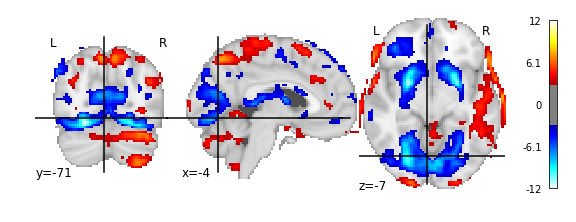

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

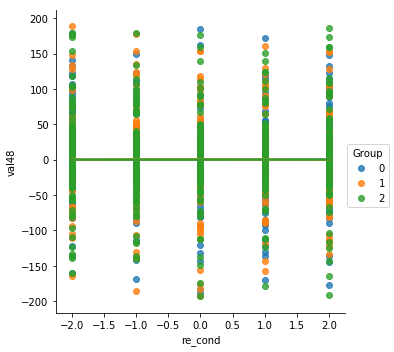

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val48      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  635.2830   
Min. group size:      43          Likelihood:             -38082.0748
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.419    0.294  1.424 0.154 -0.158  0.996
C(re_cond, Poly).Linear    -0.507    0.625 -0.812 0.417 -1.732  0.717
C(re_cond, Poly).Quadratic  0.449    0.623  0.721 0.471 -0.773  1.671
C(re_cond, Poly).Cubic      0.525    0.622  0.844 0.399 -0.694  1.745
C(re_cond, Poly)^4         -0.522   

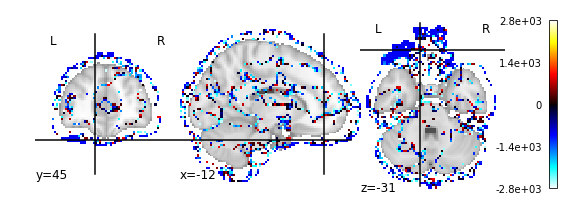

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

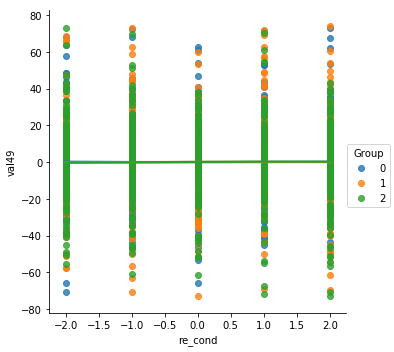

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val49      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  134.5158   
Min. group size:      43          Likelihood:             -31724.3475
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.060    0.135  0.442 0.658 -0.206  0.325
C(re_cond, Poly).Linear     0.049    0.287  0.169 0.866 -0.515  0.612
C(re_cond, Poly).Quadratic -0.108    0.287 -0.375 0.707 -0.670  0.454
C(re_cond, Poly).Cubic     -0.337    0.286 -1.176 0.240 -0.898  0.224
C(re_cond, Poly)^4         -0.357   

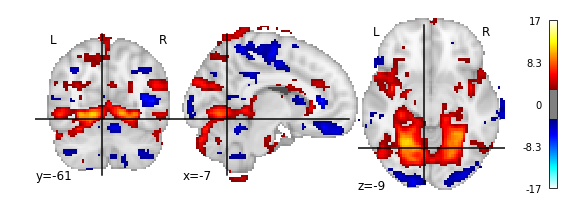

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

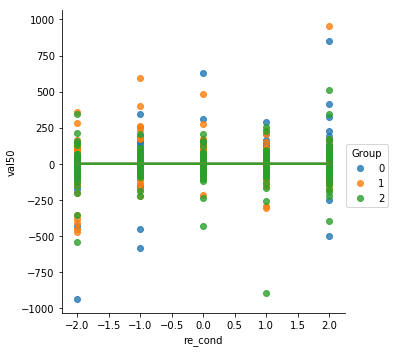

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val50      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  1689.7533  
Min. group size:      43          Likelihood:             -42089.6578
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.049    0.484  0.102 0.919 -0.898  0.997
C(re_cond, Poly).Linear     2.978    1.019  2.924 0.003  0.982  4.975
C(re_cond, Poly).Quadratic -0.877    1.017 -0.863 0.388 -2.870  1.115
C(re_cond, Poly).Cubic      1.683    1.015  1.658 0.097 -0.306  3.672
C(re_cond, Poly)^4          1.557   

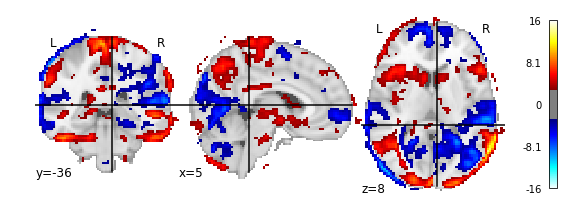

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

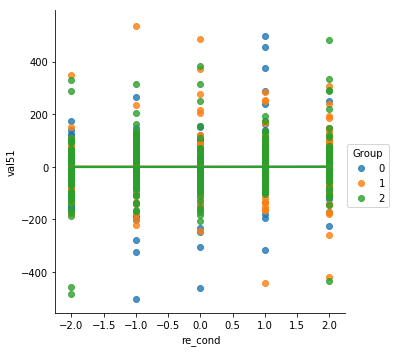

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val51      
No. Observations:     8196        Method:                 REML       
No. Groups:           140         Scale:                  1379.9609  
Min. group size:      43          Likelihood:             -41259.7716
Max. group size:      71          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.255    0.436  0.585 0.559 -0.599  1.109
C(re_cond, Poly).Linear     2.432    0.921  2.642 0.008  0.628  4.236
C(re_cond, Poly).Quadratic -0.420    0.919 -0.457 0.648 -2.221  1.381
C(re_cond, Poly).Cubic     -1.019    0.917 -1.112 0.266 -2.817  0.778
C(re_cond, Poly)^4         -1.581   

In [6]:
df=res_no_out
df.to_csv('best_data')
#df=res_no_out.loc[res_no_out['Group']==0]
for i in range(1,52):
    dep_val="val%s"%(i)
    print (dep_val)
    plot_stat_map(nil.image.index_img(images,i-1), threshold=3)
    show()
    #for x in range(3):
    #mod=smf.mixedlm("%s~C(re_cond,Poly)"%(dep_val), data=df,groups=df["ID"],eval_env=2)
    mod=smf.mixedlm("%s~C(re_cond,Poly)"%(dep_val), data=df,groups=df["ID"])
    res=mod.fit()
    #sb.barplot(data=df,x='re_cond',y=dep_val,ci=95).set_title("group=%s"%('All'))
    sb.lmplot(x='re_cond',y=dep_val,data=df,ci=95,lowess=True,hue="Group")
    plt.show()
    print(res.summary(title="group=%s"%(dep_val)))
                  


val1


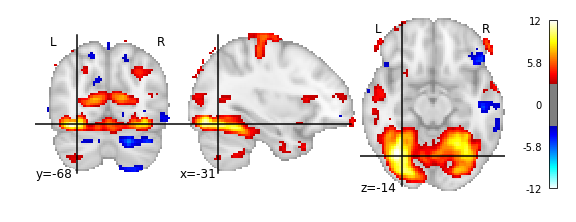

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

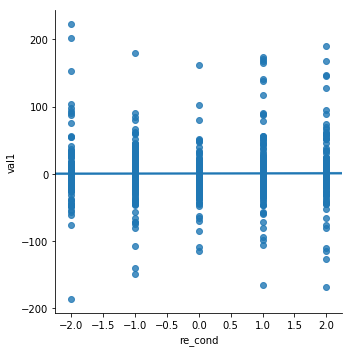

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val1       
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  487.8656   
Min. group size:      43          Likelihood:             -12147.4030
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.671    0.444  1.510 0.131 -0.200  1.541
C(re_cond, Poly).Linear     0.463    0.953  0.486 0.627 -1.405  2.332
C(re_cond, Poly).Quadratic  1.346    0.954  1.410 0.159 -0.525  3.216
C(re_cond, Poly).Cubic     -1.267    0.949 -1.335 0.182 -3.126  0.592
C(re_cond, Poly)^4         -1.057   

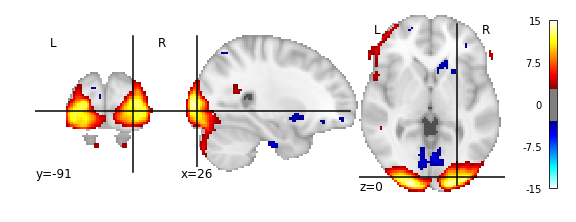

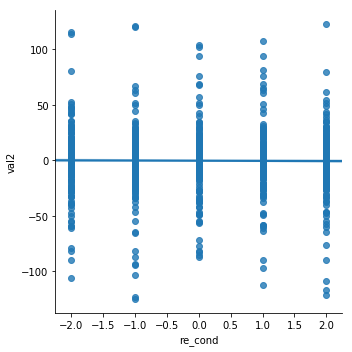

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val2       
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  300.1231   
Min. group size:      43          Likelihood:             -11500.4116
Max. group size:      69          Converged:              Yes        
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.401    0.396 -1.012 0.311 -1.177  0.375
C(re_cond, Poly).Linear    -0.509    0.748 -0.680 0.496 -1.975  0.957
C(re_cond, Poly).Quadratic -0.362    0.749 -0.484 0.628 -1.831  1.106
C(re_cond, Poly).Cubic     -0.887    0.745 -1.191 0.234 -2.346  0.573
C(re_cond, Poly)^4          0.240   

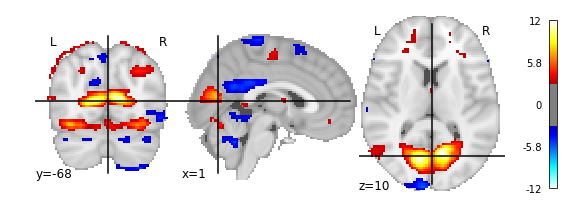

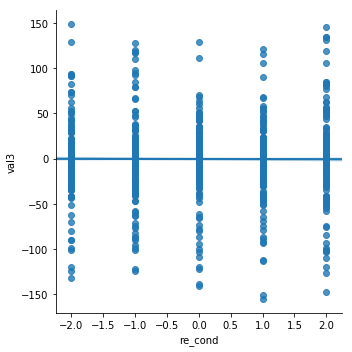

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val3       
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  553.7792   
Min. group size:      43          Likelihood:             -12324.6685
Max. group size:      69          Converged:              Yes        
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.513    0.553 -0.928 0.354 -1.597  0.571
C(re_cond, Poly).Linear    -0.376    1.016 -0.370 0.711 -2.368  1.616
C(re_cond, Poly).Quadratic  1.170    1.018  1.150 0.250 -0.825  3.164
C(re_cond, Poly).Cubic      0.358    1.011  0.354 0.724 -1.625  2.340
C(re_cond, Poly)^4         -0.522   

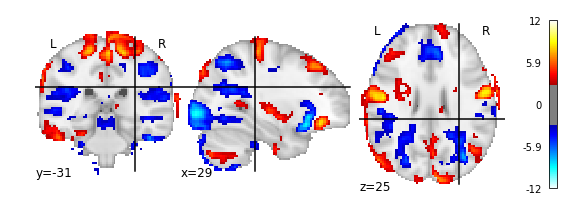

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

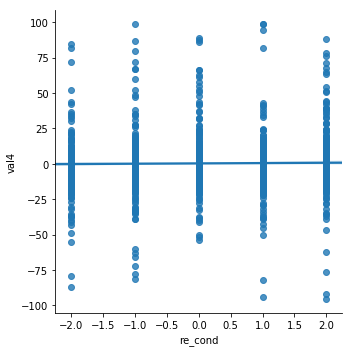

               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    val4       
No. Observations:     2692       Method:                REML       
No. Groups:           46         Scale:                 201.8029   
Min. group size:      43         Likelihood:            -10960.8249
Max. group size:      69         Converged:             No         
Mean group size:      58.5                                         
-------------------------------------------------------------------
                           Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                  0.281    0.282 0.997 0.319 -0.271  0.834
C(re_cond, Poly).Linear    0.705    0.613 1.150 0.250 -0.496  1.907
C(re_cond, Poly).Quadratic 0.019    0.614 0.030 0.976 -1.185  1.222
C(re_cond, Poly).Cubic     0.723    0.610 1.185 0.236 -0.473  1.918
C(re_cond, Poly)^4         1.032    0.613 1.682 0.093 -0.170  2

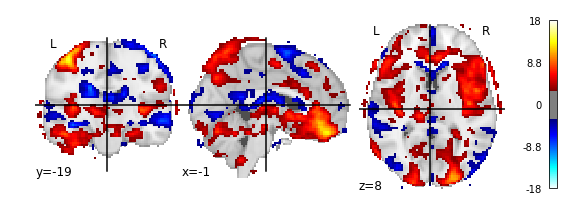

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

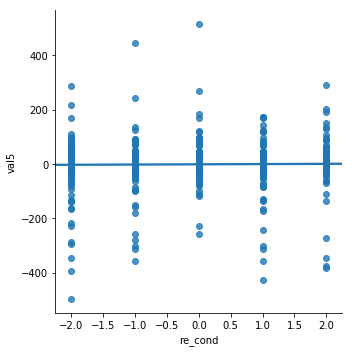

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val5       
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  1796.0440  
Min. group size:      43          Likelihood:             -13898.1835
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -1.368    0.848 -1.613 0.107 -3.030  0.294
C(re_cond, Poly).Linear     2.725    1.830  1.489 0.136 -0.862  6.312
C(re_cond, Poly).Quadratic -1.334    1.831 -0.728 0.466 -4.923  2.256
C(re_cond, Poly).Cubic      0.447    1.820  0.245 0.806 -3.121  4.015
C(re_cond, Poly)^4          3.565   

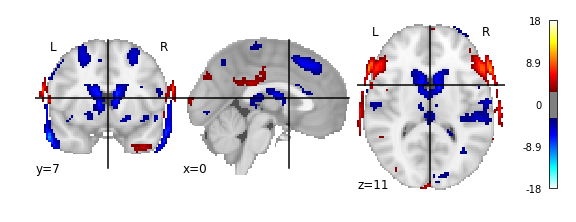

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

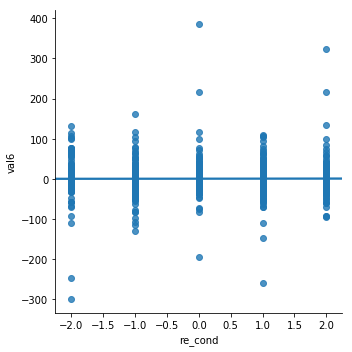

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val6       
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  577.7674   
Min. group size:      43          Likelihood:             -12374.5447
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.559    0.482  1.159 0.246 -0.386  1.505
C(re_cond, Poly).Linear     0.410    1.038  0.395 0.693 -1.624  2.445
C(re_cond, Poly).Quadratic -0.230    1.039 -0.222 0.824 -2.266  1.805
C(re_cond, Poly).Cubic     -0.456    1.032 -0.441 0.659 -2.479  1.568
C(re_cond, Poly)^4          1.314   

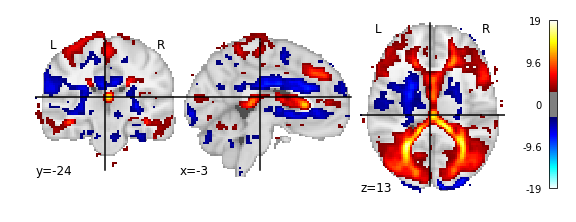

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

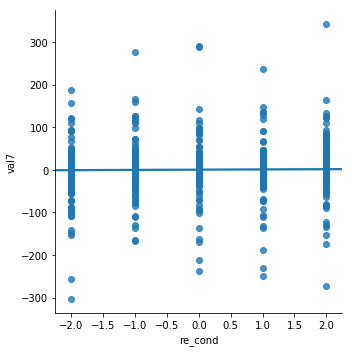

                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     val7       
No. Observations:      2692        Method:                 REML       
No. Groups:            46          Scale:                  970.8878   
Min. group size:       43          Likelihood:             -13161.9442
Max. group size:       69          Converged:              No         
Mean group size:       58.5                                           
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.267    4.634  0.058 0.954 -8.815  9.348
C(re_cond, Poly).Linear      1.714    1.349  1.271 0.204 -0.930  4.358
C(re_cond, Poly).Quadratic  -0.663    1.349 -0.491 0.623 -3.307  1.982
C(re_cond, Poly).Cubic       1.770    1.342  1.319 0.187 -0.859  4.400
C(re_cond, Poly)^4    

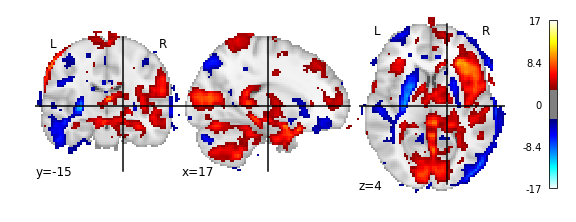

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

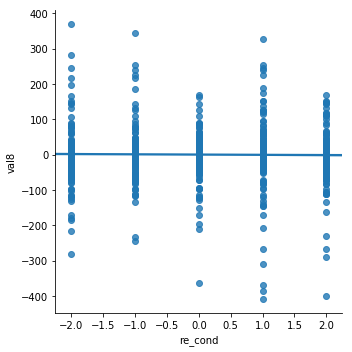

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val8       
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  1820.2634  
Min. group size:      43          Likelihood:             -13916.1242
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.046    0.853 -0.054 0.957 -1.717  1.625
C(re_cond, Poly).Linear    -2.288    1.841 -1.243 0.214 -5.897  1.321
C(re_cond, Poly).Quadratic -0.965    1.844 -0.523 0.601 -4.579  2.649
C(re_cond, Poly).Cubic      0.111    1.832  0.060 0.952 -3.480  3.701
C(re_cond, Poly)^4         -2.638   

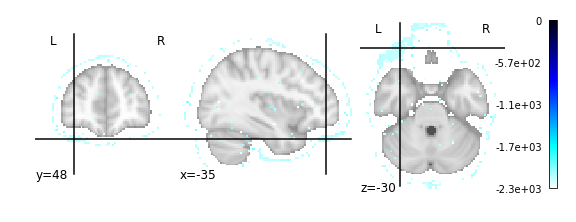

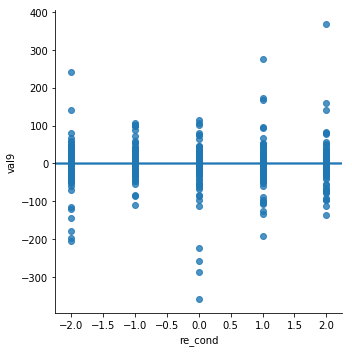

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val9       
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  630.0399   
Min. group size:      43          Likelihood:             -12496.6110
Max. group size:      69          Converged:              Yes        
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.450    0.572 -0.788 0.431 -1.572  0.671
C(re_cond, Poly).Linear     0.152    1.084  0.140 0.889 -1.973  2.276
C(re_cond, Poly).Quadratic  0.831    1.085  0.766 0.444 -1.296  2.958
C(re_cond, Poly).Cubic      0.734    1.079  0.681 0.496 -1.380  2.848
C(re_cond, Poly)^4         -2.065   

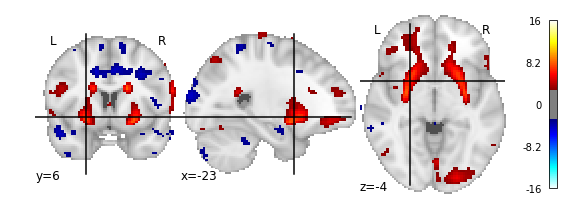

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

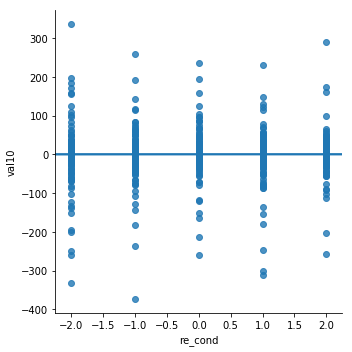

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val10      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  1067.7821  
Min. group size:      43          Likelihood:             -13198.8839
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.079    0.644  0.122 0.903 -1.183  1.341
C(re_cond, Poly).Linear     0.020    1.410  0.014 0.989 -2.744  2.784
C(re_cond, Poly).Quadratic -0.194    1.412 -0.137 0.891 -2.961  2.573
C(re_cond, Poly).Cubic      1.126    1.403  0.803 0.422 -1.624  3.876
C(re_cond, Poly)^4          1.298   

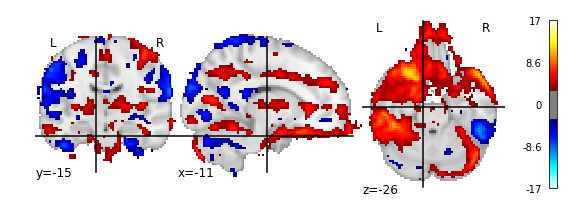

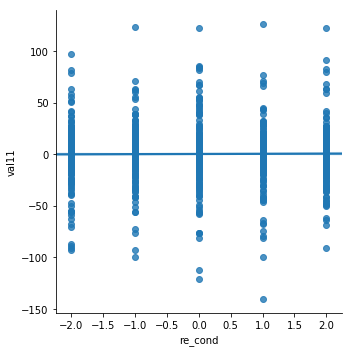

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val11      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  295.8663   
Min. group size:      43          Likelihood:             -11486.2042
Max. group size:      69          Converged:              Yes        
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.160    0.439  0.365 0.715 -0.700  1.021
C(re_cond, Poly).Linear     0.453    0.743  0.609 0.543 -1.004  1.909
C(re_cond, Poly).Quadratic -0.209    0.744 -0.280 0.779 -1.667  1.249
C(re_cond, Poly).Cubic      1.084    0.739  1.465 0.143 -0.366  2.533
C(re_cond, Poly)^4          0.079   

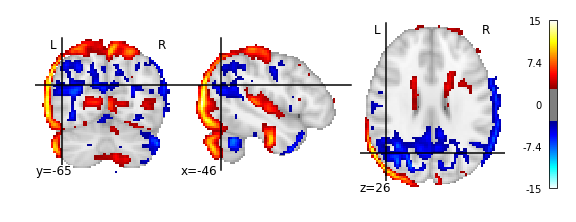

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

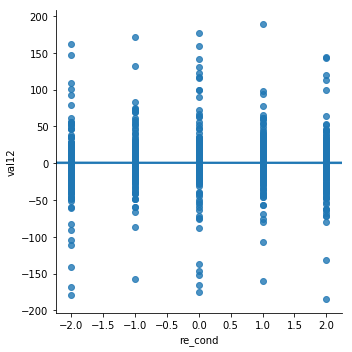

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val12      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  525.1269   
Min. group size:      43          Likelihood:             -12245.9284
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.510    0.457  1.115 0.265 -0.386  1.405
C(re_cond, Poly).Linear    -0.018    0.989 -0.018 0.986 -1.956  1.920
C(re_cond, Poly).Quadratic -1.606    0.990 -1.621 0.105 -3.547  0.335
C(re_cond, Poly).Cubic      0.211    0.984  0.215 0.830 -1.718  2.141
C(re_cond, Poly)^4         -0.569   

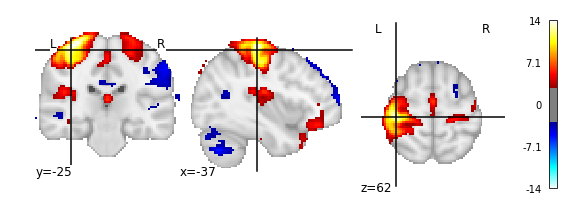

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

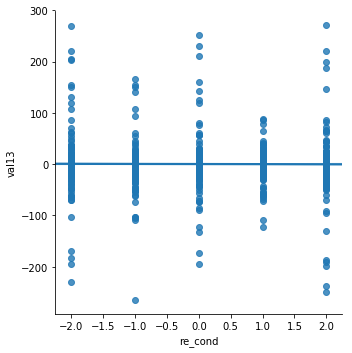

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val13      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  767.4846   
Min. group size:      43          Likelihood:             -12755.4698
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.346    0.549  0.631 0.528 -0.730  1.422
C(re_cond, Poly).Linear    -0.625    1.195 -0.523 0.601 -2.968  1.718
C(re_cond, Poly).Quadratic -0.048    1.197 -0.040 0.968 -2.395  2.298
C(re_cond, Poly).Cubic     -0.259    1.190 -0.218 0.828 -2.591  2.072
C(re_cond, Poly)^4          0.940   

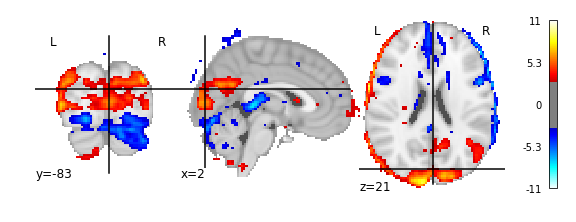

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

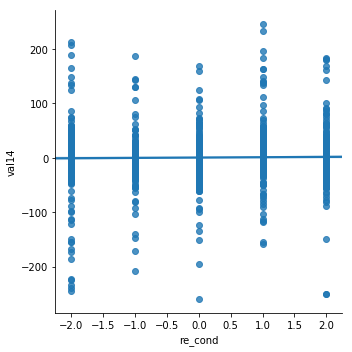

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val14      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  1079.4623  
Min. group size:      43          Likelihood:             -13214.4873
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.463    0.662  0.699 0.484 -0.835  1.760
C(re_cond, Poly).Linear     1.877    1.419  1.322 0.186 -0.905  4.659
C(re_cond, Poly).Quadratic -0.404    1.421 -0.284 0.776 -3.188  2.381
C(re_cond, Poly).Cubic     -2.186    1.411 -1.549 0.121 -4.952  0.580
C(re_cond, Poly)^4         -1.002   

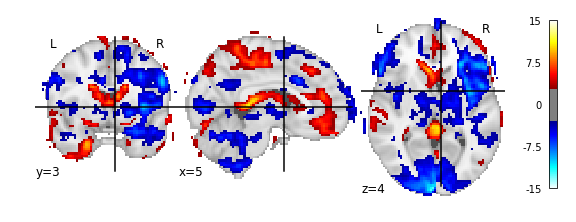

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

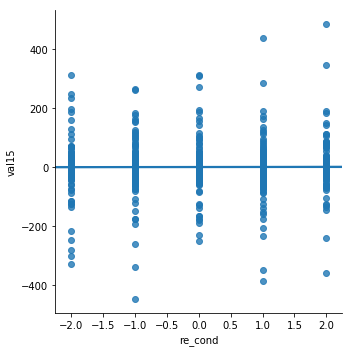

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val15      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  1829.8850  
Min. group size:      43          Likelihood:             -13922.7710
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.062    0.847 -0.073 0.941 -1.721  1.597
C(re_cond, Poly).Linear     0.658    1.846  0.356 0.722 -2.960  4.276
C(re_cond, Poly).Quadratic  0.505    1.848  0.273 0.785 -3.118  4.128
C(re_cond, Poly).Cubic      1.051    1.838  0.572 0.568 -2.551  4.652
C(re_cond, Poly)^4          1.867   

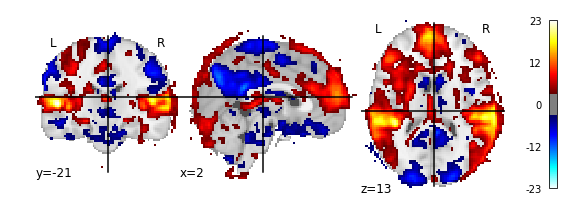

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

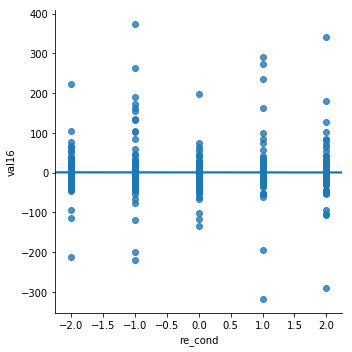

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val16      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  634.6495   
Min. group size:      43          Likelihood:             -12500.0421
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.731    0.498  1.467 0.142 -0.246  1.707
C(re_cond, Poly).Linear    -0.161    1.087 -0.149 0.882 -2.292  1.969
C(re_cond, Poly).Quadratic -0.251    1.089 -0.230 0.818 -2.384  1.883
C(re_cond, Poly).Cubic      0.785    1.082  0.726 0.468 -1.335  2.905
C(re_cond, Poly)^4         -1.739   

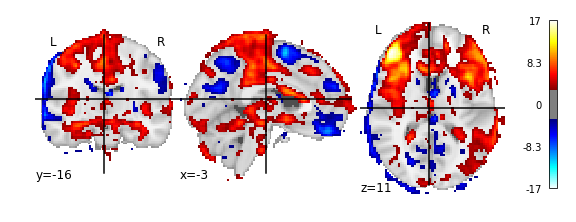

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

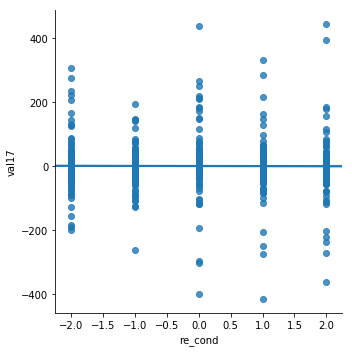

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val17      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  1563.0517  
Min. group size:      43          Likelihood:             -13711.0973
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.477    0.784  0.609 0.542 -1.059  2.014
C(re_cond, Poly).Linear    -0.818    1.706 -0.479 0.632 -4.162  2.526
C(re_cond, Poly).Quadratic -0.554    1.708 -0.324 0.746 -3.903  2.794
C(re_cond, Poly).Cubic      0.185    1.698  0.109 0.913 -3.142  3.513
C(re_cond, Poly)^4          1.823   

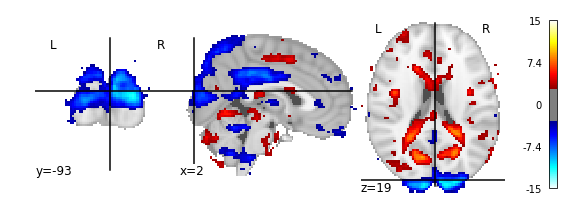

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

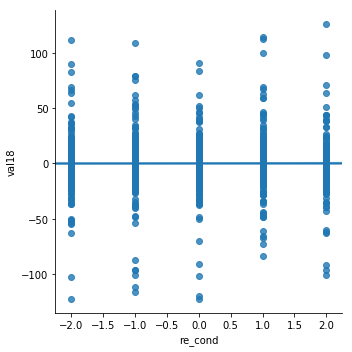

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val18      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  262.7564   
Min. group size:      43          Likelihood:             -11315.2787
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.003    0.320 -0.009 0.993 -0.631  0.625
C(re_cond, Poly).Linear     0.112    0.700  0.160 0.873 -1.259  1.483
C(re_cond, Poly).Quadratic -0.009    0.700 -0.013 0.989 -1.382  1.364
C(re_cond, Poly).Cubic     -0.807    0.696 -1.160 0.246 -2.171  0.557
C(re_cond, Poly)^4         -0.733   

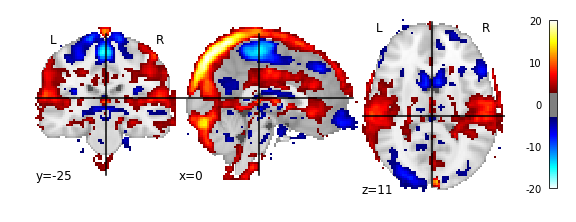

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

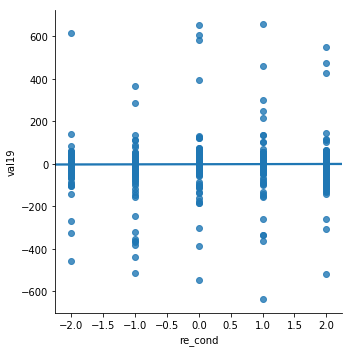

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val19      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  3060.9199  
Min. group size:      43          Likelihood:             -14614.2088
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -1.356    1.101 -1.231 0.218 -3.515  0.802
C(re_cond, Poly).Linear     1.742    2.388  0.730 0.466 -2.937  6.422
C(re_cond, Poly).Quadratic  0.506    2.391  0.212 0.832 -4.179  5.192
C(re_cond, Poly).Cubic     -2.280    2.376 -0.960 0.337 -6.937  2.377
C(re_cond, Poly)^4          2.905   

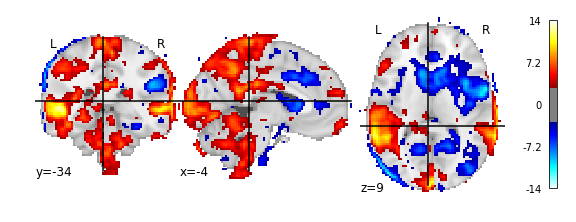

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

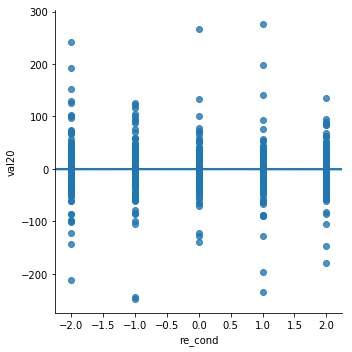

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val20      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  667.6141   
Min. group size:      43          Likelihood:             -12568.3125
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.510    0.513 -0.993 0.321 -1.516  0.496
C(re_cond, Poly).Linear    -0.063    1.115 -0.056 0.955 -2.248  2.123
C(re_cond, Poly).Quadratic  0.566    1.117  0.507 0.612 -1.622  2.754
C(re_cond, Poly).Cubic      0.083    1.110  0.074 0.941 -2.092  2.257
C(re_cond, Poly)^4          0.412   

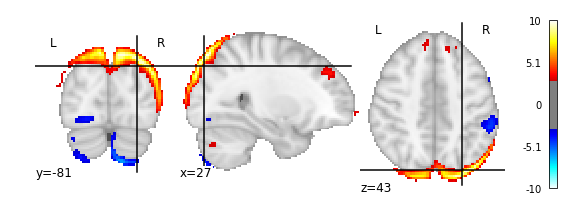

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

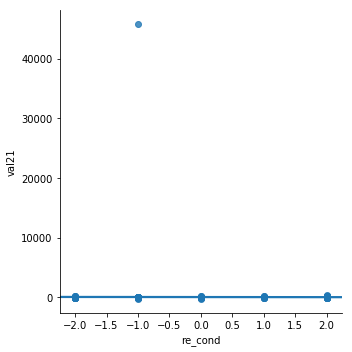

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      val21      
No. Observations:       2692         Method:                  REML       
No. Groups:             46           Scale:                   780569.1291
Min. group size:        43           Likelihood:              -22059.1010
Max. group size:        69           Converged:               No         
Mean group size:        58.5                                             
-------------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------------
Intercept                   16.787   17.642  0.952 0.341  -17.791  51.365
C(re_cond, Poly).Linear    -24.929   38.129 -0.654 0.513  -99.661  49.802
C(re_cond, Poly).Quadratic -20.344   38.181 -0.533 0.594  -95.177  54.490
C(re_cond, Poly).Cubic      51.654   37.939  1.362 0.173

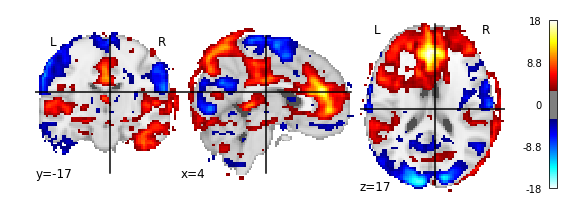

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

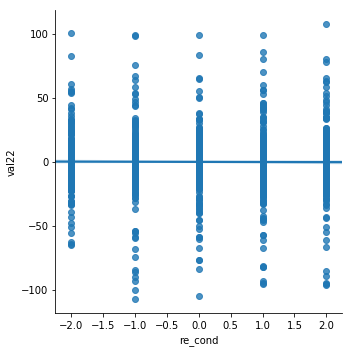

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val22      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  292.3300   
Min. group size:      43          Likelihood:             -11458.5823
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.207    0.338 -0.611 0.541 -0.869  0.456
C(re_cond, Poly).Linear    -0.342    0.738 -0.464 0.643 -1.788  1.104
C(re_cond, Poly).Quadratic  1.312    0.739  1.776 0.076 -0.136  2.761
C(re_cond, Poly).Cubic      0.119    0.734  0.162 0.871 -1.320  1.558
C(re_cond, Poly)^4          0.507   

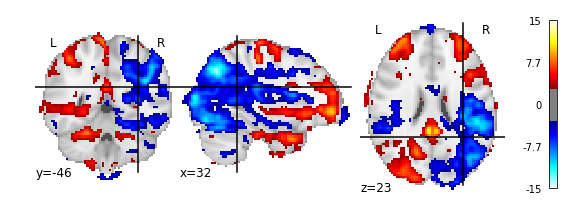

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

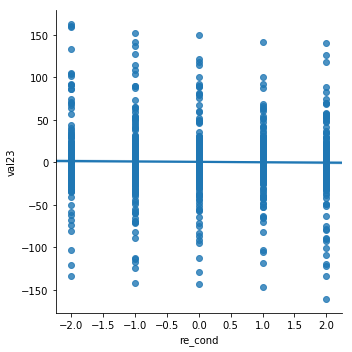

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val23      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  581.2303   
Min. group size:      43          Likelihood:             -12382.1599
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.533    0.479  1.112 0.266 -0.406  1.472
C(re_cond, Poly).Linear    -1.481    1.041 -1.423 0.155 -3.520  0.559
C(re_cond, Poly).Quadratic  0.633    1.042  0.608 0.543 -1.409  2.675
C(re_cond, Poly).Cubic     -0.264    1.035 -0.255 0.799 -2.293  1.765
C(re_cond, Poly)^4          0.366   

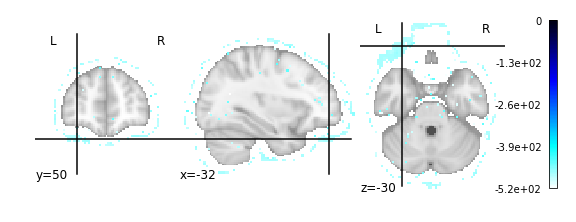

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

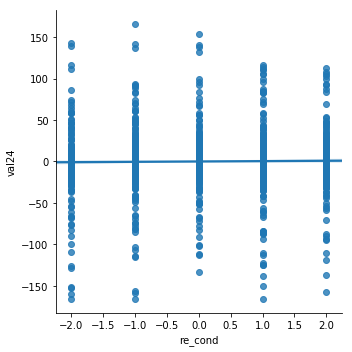

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val24      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  692.4881   
Min. group size:      43          Likelihood:             -12617.8074
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.014    0.527 -0.027 0.979 -1.047  1.019
C(re_cond, Poly).Linear     1.322    1.136  1.163 0.245 -0.905  3.549
C(re_cond, Poly).Quadratic -1.112    1.137 -0.978 0.328 -3.341  1.117
C(re_cond, Poly).Cubic      0.834    1.130  0.738 0.460 -1.381  3.049
C(re_cond, Poly)^4          0.424   

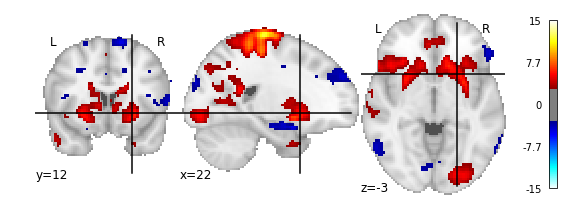

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

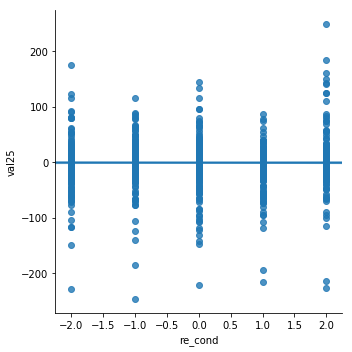

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val25      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  705.7353   
Min. group size:      43          Likelihood:             -12643.2821
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -1.010    0.533 -1.896 0.058 -2.054  0.034
C(re_cond, Poly).Linear    -0.115    1.147 -0.101 0.920 -2.363  2.132
C(re_cond, Poly).Quadratic  2.309    1.148  2.011 0.044  0.059  4.560
C(re_cond, Poly).Cubic      2.116    1.141  1.854 0.064 -0.120  4.352
C(re_cond, Poly)^4          0.639   

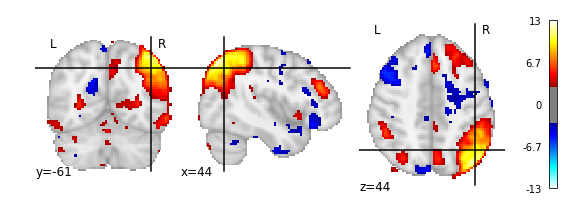

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

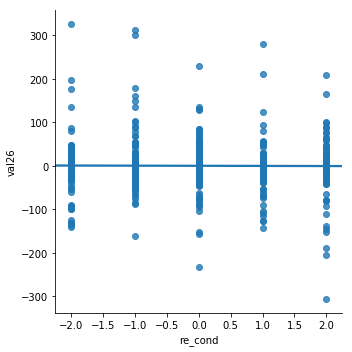

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val26      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  780.1232   
Min. group size:      43          Likelihood:             -12777.5997
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.231    0.556  0.416 0.678 -0.858  1.320
C(re_cond, Poly).Linear    -0.859    1.205 -0.713 0.476 -3.222  1.503
C(re_cond, Poly).Quadratic -0.903    1.207 -0.748 0.455 -3.268  1.463
C(re_cond, Poly).Cubic      1.211    1.199  1.010 0.313 -1.139  3.562
C(re_cond, Poly)^4         -0.812   

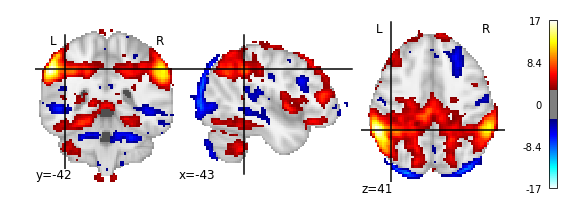

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

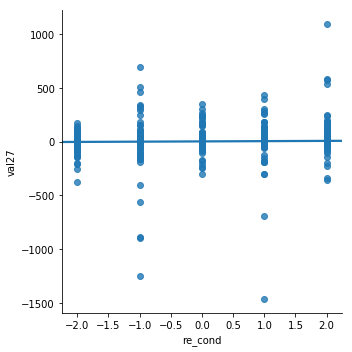

                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     val27      
No. Observations:       2692        Method:                 REML       
No. Groups:             46          Scale:                  5229.1915  
Min. group size:        43          Likelihood:             -15424.1308
Max. group size:        69          Converged:              No         
Mean group size:        58.5                                           
-----------------------------------------------------------------------
                            Coef.   Std.Err.   z   P>|z|  [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     1.306   10.753 0.121 0.903 -19.770 22.382
C(re_cond, Poly).Linear       7.650    3.130 2.444 0.015   1.515 13.786
C(re_cond, Poly).Quadratic    1.893    3.132 0.604 0.546  -4.245  8.031
C(re_cond, Poly).Cubic        1.016    3.114 0.326 0.744  -5.088  7.119
C(re_cond

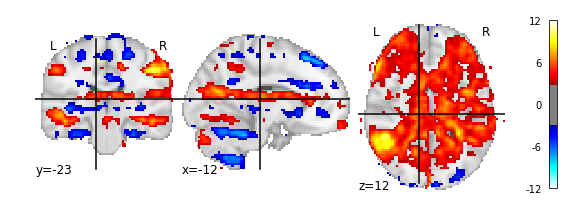

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

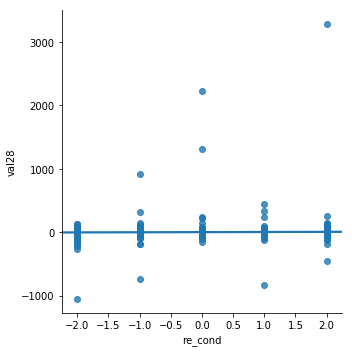

                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     val28      
No. Observations:      2692        Method:                 REML       
No. Groups:            46          Scale:                  8451.4257  
Min. group size:       43          Likelihood:             -15978.4060
Max. group size:       69          Converged:              No         
Mean group size:       58.5                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------
Intercept                   2.203    1.818  1.212 0.226  -1.361  5.767
C(re_cond, Poly).Linear     6.899    3.969  1.738 0.082  -0.880 14.679
C(re_cond, Poly).Quadratic -3.595    3.974 -0.905 0.366 -11.385  4.195
C(re_cond, Poly).Cubic      4.430    3.949  1.122 0.262  -3.309 12.170
C(re_cond, Poly)^4    

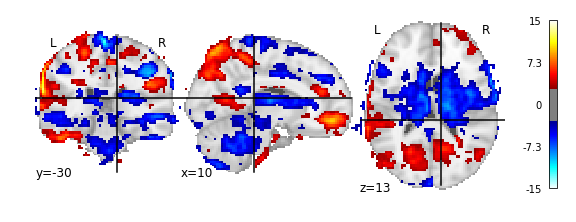

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

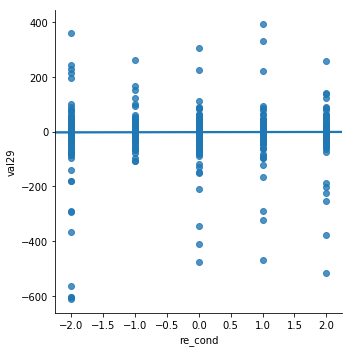

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val29      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  1959.5171  
Min. group size:      43          Likelihood:             -14014.8492
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -2.105    0.878 -2.396 0.017 -3.827 -0.383
C(re_cond, Poly).Linear     1.123    1.911  0.588 0.557 -2.622  4.868
C(re_cond, Poly).Quadratic -3.251    1.913 -1.699 0.089 -7.000  0.498
C(re_cond, Poly).Cubic      2.336    1.901  1.229 0.219 -1.390  6.062
C(re_cond, Poly)^4         -2.048   

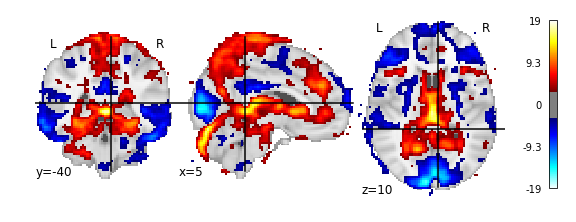

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

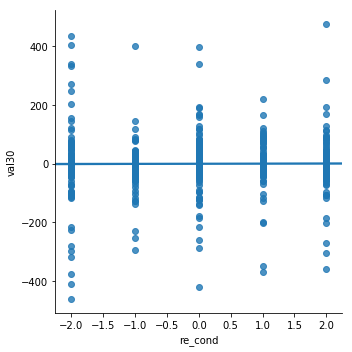

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val30      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  2004.5540  
Min. group size:      43          Likelihood:             -14045.5377
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.342    0.892 -0.383 0.702 -2.089  1.406
C(re_cond, Poly).Linear     1.251    1.932  0.647 0.517 -2.536  5.038
C(re_cond, Poly).Quadratic -0.181    1.935 -0.094 0.925 -3.973  3.611
C(re_cond, Poly).Cubic     -0.029    1.923 -0.015 0.988 -3.798  3.739
C(re_cond, Poly)^4         -0.131   

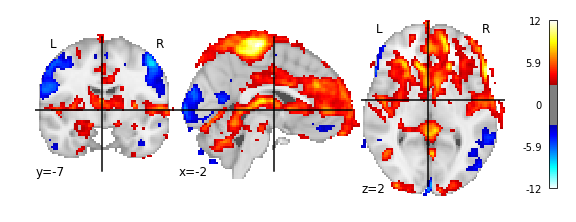

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

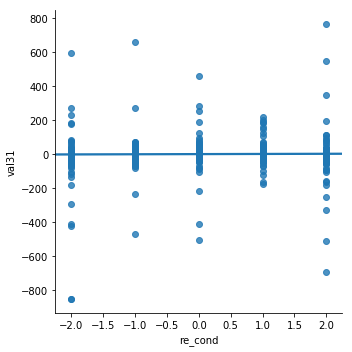

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val31      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  2632.7245  
Min. group size:      43          Likelihood:             -14411.3514
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.704    1.012 -0.695 0.487 -2.688  1.280
C(re_cond, Poly).Linear     2.945    2.215  1.330 0.184 -1.396  7.286
C(re_cond, Poly).Quadratic -3.993    2.217 -1.801 0.072 -8.338  0.353
C(re_cond, Poly).Cubic     -0.011    2.203 -0.005 0.996 -4.330  4.307
C(re_cond, Poly)^4         -0.561   

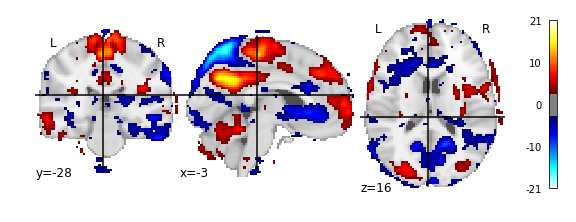

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

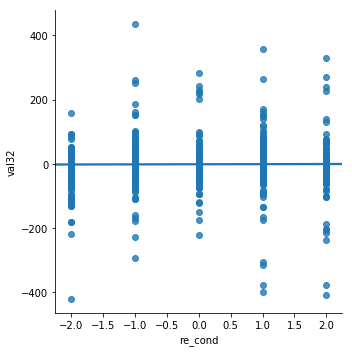

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val32      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  1668.5449  
Min. group size:      43          Likelihood:             -13798.6775
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -1.059    0.807 -1.312 0.189 -2.640  0.522
C(re_cond, Poly).Linear     1.139    1.763  0.646 0.518 -2.316  4.593
C(re_cond, Poly).Quadratic -4.867    1.765 -2.758 0.006 -8.327 -1.408
C(re_cond, Poly).Cubic      1.735    1.754  0.989 0.323 -1.703  5.172
C(re_cond, Poly)^4         -0.342   

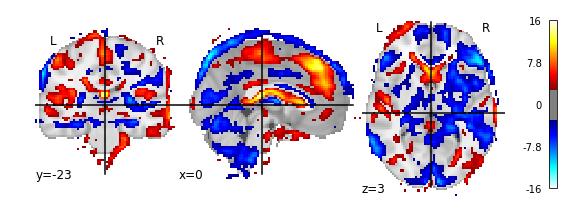

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

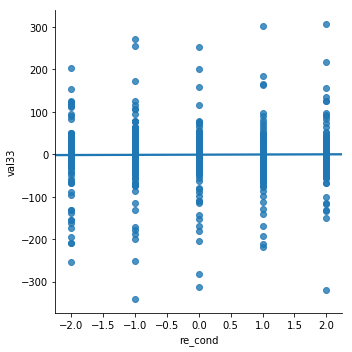

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val33      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  1170.6936  
Min. group size:      43          Likelihood:             -13323.1316
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.928    0.684 -1.357 0.175 -2.268  0.413
C(re_cond, Poly).Linear     1.340    1.477  0.908 0.364 -1.554  4.234
C(re_cond, Poly).Quadratic  1.398    1.479  0.945 0.344 -1.500  4.296
C(re_cond, Poly).Cubic      2.207    1.469  1.502 0.133 -0.673  5.087
C(re_cond, Poly)^4         -0.614   

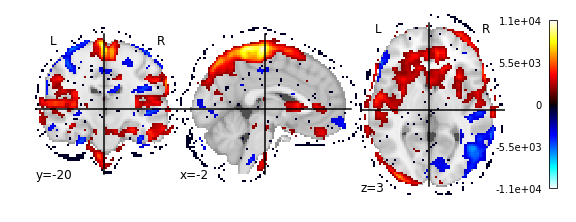

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

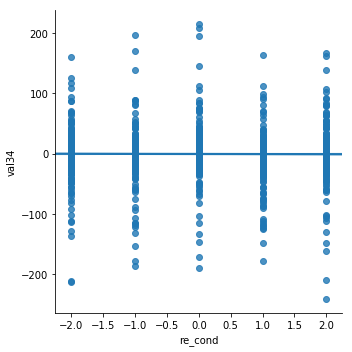

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val34      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  821.7620   
Min. group size:      43          Likelihood:             -12847.6675
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.608    0.573 -1.061 0.288 -1.732  0.515
C(re_cond, Poly).Linear    -0.487    1.237 -0.394 0.694 -2.912  1.937
C(re_cond, Poly).Quadratic  0.104    1.239  0.084 0.933 -2.326  2.533
C(re_cond, Poly).Cubic      2.148    1.231  1.744 0.081 -0.265  4.561
C(re_cond, Poly)^4          2.593   

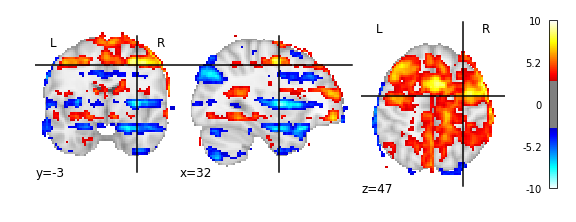

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

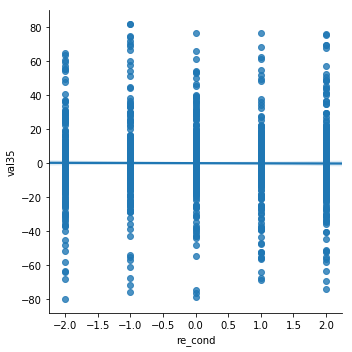

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val35      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  235.4715   
Min. group size:      43          Likelihood:             -11168.1598
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.112    0.305  0.368 0.713 -0.485  0.709
C(re_cond, Poly).Linear    -0.289    0.662 -0.436 0.663 -1.587  1.009
C(re_cond, Poly).Quadratic -0.328    0.663 -0.494 0.621 -1.628  0.972
C(re_cond, Poly).Cubic      1.083    0.659  1.642 0.101 -0.209  2.374
C(re_cond, Poly)^4          0.476   

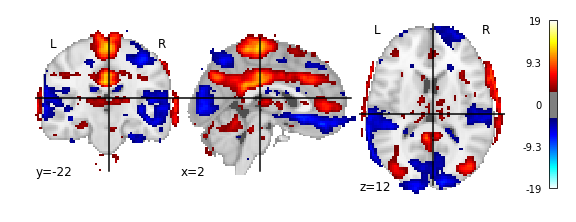

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

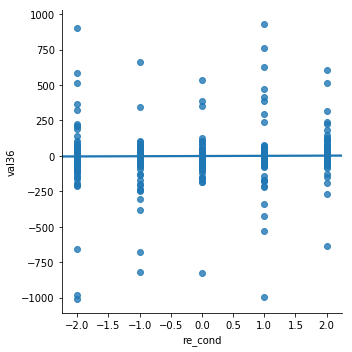

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val36      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  5484.2453  
Min. group size:      43          Likelihood:             -15397.3155
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.896    1.462 -0.613 0.540 -3.761  1.968
C(re_cond, Poly).Linear     4.230    3.196  1.324 0.186 -2.034 10.493
C(re_cond, Poly).Quadratic  2.090    3.200  0.653 0.514 -4.182  8.362
C(re_cond, Poly).Cubic     -2.856    3.180 -0.898 0.369 -9.088  3.376
C(re_cond, Poly)^4          1.681   

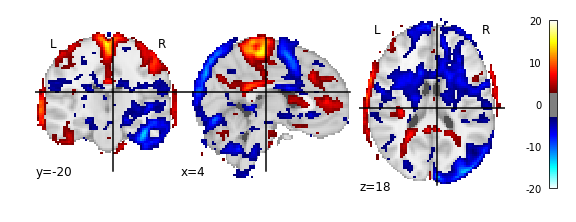

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

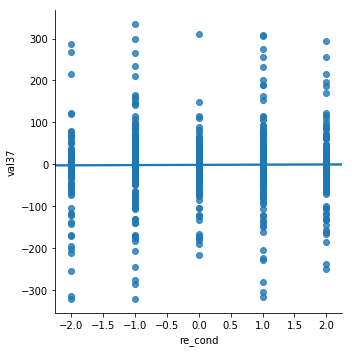

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val37      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  1913.5310  
Min. group size:      43          Likelihood:             -13982.9979
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -1.100    0.869 -1.265 0.206 -2.803  0.604
C(re_cond, Poly).Linear     1.514    1.888  0.802 0.423 -2.186  5.214
C(re_cond, Poly).Quadratic -0.263    1.890 -0.139 0.889 -3.968  3.442
C(re_cond, Poly).Cubic      1.013    1.878  0.539 0.590 -2.668  4.695
C(re_cond, Poly)^4         -1.690   

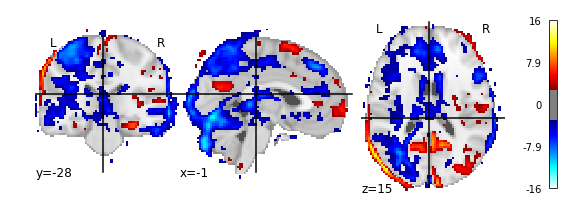

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

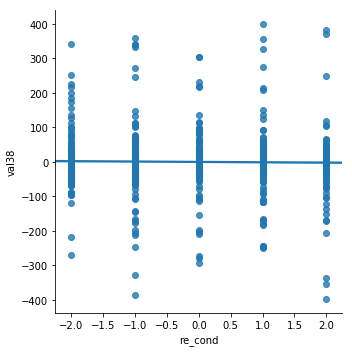

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val38      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  2055.7135  
Min. group size:      43          Likelihood:             -14079.0725
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.132    0.896 -0.147 0.883 -1.889  1.625
C(re_cond, Poly).Linear    -3.340    1.957 -1.707 0.088 -7.176  0.496
C(re_cond, Poly).Quadratic  0.515    1.959  0.263 0.793 -3.325  4.354
C(re_cond, Poly).Cubic     -1.372    1.947 -0.705 0.481 -5.188  2.444
C(re_cond, Poly)^4          0.332   

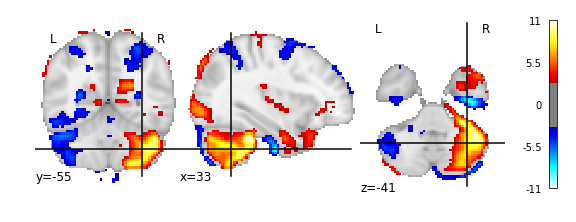

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

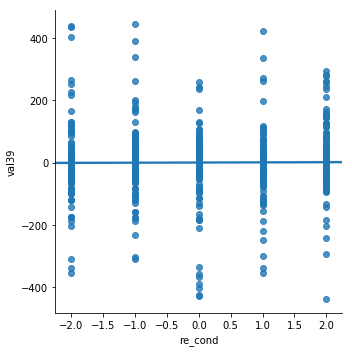

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val39      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  2848.0139  
Min. group size:      43          Likelihood:             -14517.0768
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.174    1.056  0.165 0.869 -1.896  2.243
C(re_cond, Poly).Linear     1.773    2.303  0.770 0.441 -2.741  6.286
C(re_cond, Poly).Quadratic  3.484    2.307  1.511 0.131 -1.037  8.005
C(re_cond, Poly).Cubic      2.379    2.292  1.038 0.299 -2.112  6.871
C(re_cond, Poly)^4         -3.794   

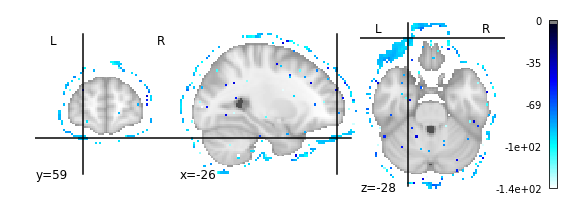

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

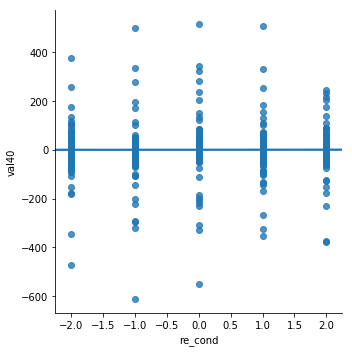

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val40      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  2178.5548  
Min. group size:      43          Likelihood:             -14157.8875
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.523    0.941 -0.556 0.578 -2.367  1.321
C(re_cond, Poly).Linear     0.359    2.014  0.178 0.859 -3.589  4.307
C(re_cond, Poly).Quadratic -0.576    2.017 -0.285 0.775 -4.529  3.378
C(re_cond, Poly).Cubic      0.167    2.005  0.083 0.934 -3.763  4.097
C(re_cond, Poly)^4          0.556   

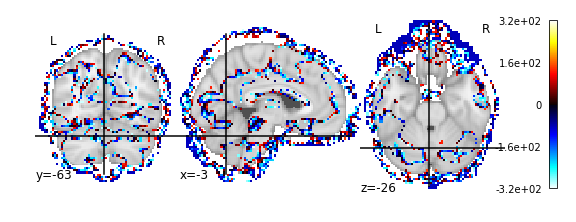

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

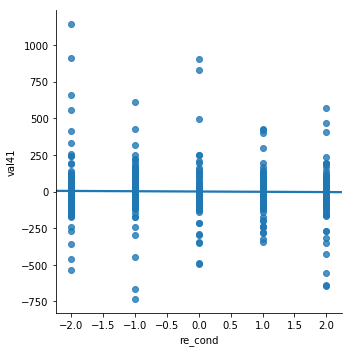

                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     val41      
No. Observations:      2692        Method:                 REML       
No. Groups:            46          Scale:                  5800.4330  
Min. group size:       43          Likelihood:             -15473.0287
Max. group size:       69          Converged:              No         
Mean group size:       58.5                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.175    1.517  0.115 0.908  -2.799  3.148
C(re_cond, Poly).Linear    -6.046    3.287 -1.840 0.066 -12.488  0.395
C(re_cond, Poly).Quadratic  1.422    3.291  0.432 0.666  -5.028  7.873
C(re_cond, Poly).Cubic     -1.518    3.271 -0.464 0.643  -7.928  4.892
C(re_cond, Poly)^4    

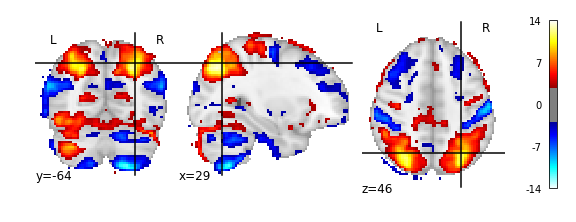

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

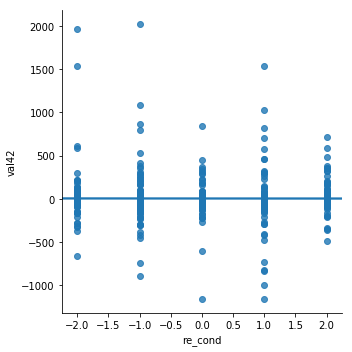

                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     val42      
No. Observations:      2692        Method:                 REML       
No. Groups:            46          Scale:                  13972.0073 
Min. group size:       43          Likelihood:             -16654.0713
Max. group size:       69          Converged:              No         
Mean group size:       58.5                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------
Intercept                   3.301    2.351  1.404 0.160  -1.307  7.910
C(re_cond, Poly).Linear    -0.854    5.101 -0.167 0.867 -10.852  9.145
C(re_cond, Poly).Quadratic  4.507    5.108  0.882 0.378  -5.505 14.519
C(re_cond, Poly).Cubic      2.241    5.076  0.441 0.659  -7.709 12.190
C(re_cond, Poly)^4    

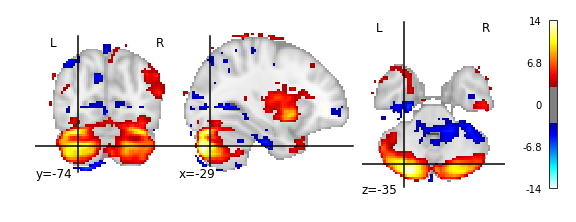

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

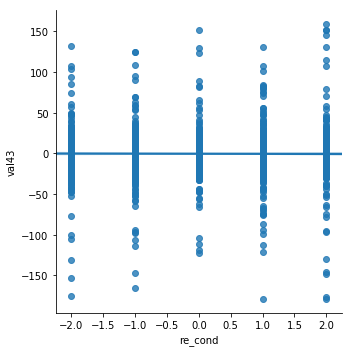

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val43      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  549.4199   
Min. group size:      43          Likelihood:             -12306.6806
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.428    0.467 -0.916 0.359 -1.344  0.488
C(re_cond, Poly).Linear    -0.326    1.012 -0.323 0.747 -2.309  1.656
C(re_cond, Poly).Quadratic  0.830    1.013  0.819 0.413 -1.156  2.816
C(re_cond, Poly).Cubic      0.380    1.007  0.377 0.706 -1.594  2.353
C(re_cond, Poly)^4          0.636   

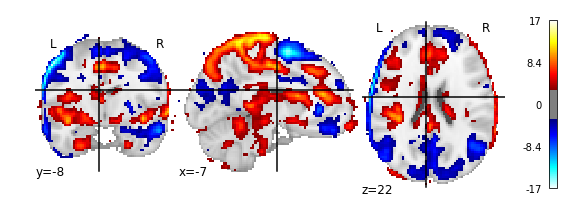

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

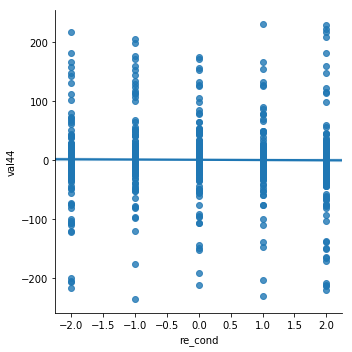

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val44      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  1059.1661  
Min. group size:      43          Likelihood:             -13187.9801
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.301    0.641  0.469 0.639 -0.956  1.558
C(re_cond, Poly).Linear    -1.220    1.405 -0.868 0.385 -3.974  1.534
C(re_cond, Poly).Quadratic -1.979    1.406 -1.407 0.159 -4.735  0.777
C(re_cond, Poly).Cubic      0.910    1.397  0.651 0.515 -1.829  3.649
C(re_cond, Poly)^4         -2.059   

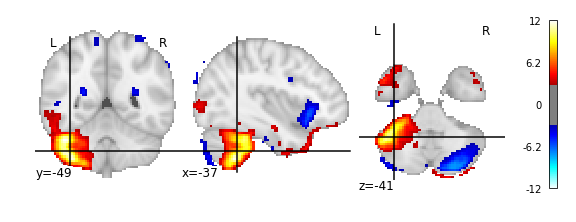

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

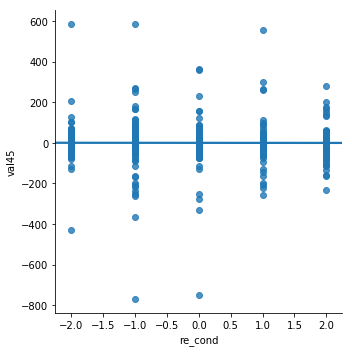

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val45      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  2105.8803  
Min. group size:      43          Likelihood:             -14111.3293
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.150    0.905 -0.166 0.868 -1.923  1.623
C(re_cond, Poly).Linear    -0.495    1.980 -0.250 0.802 -4.377  3.386
C(re_cond, Poly).Quadratic  0.648    1.983  0.327 0.744 -3.238  4.535
C(re_cond, Poly).Cubic     -1.966    1.970 -0.998 0.318 -5.829  1.896
C(re_cond, Poly)^4         -0.750   

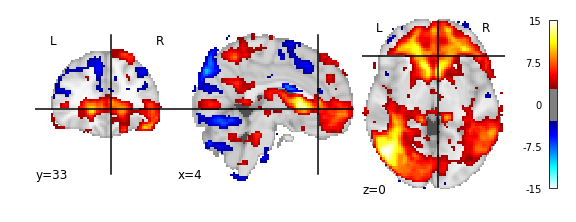

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

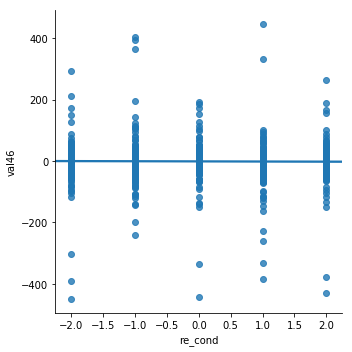

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val46      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  1593.2521  
Min. group size:      43          Likelihood:             -13737.2570
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.991    0.800 -1.239 0.215 -2.559  0.576
C(re_cond, Poly).Linear    -1.478    1.723 -0.858 0.391 -4.855  1.898
C(re_cond, Poly).Quadratic  0.124    1.725  0.072 0.943 -3.257  3.505
C(re_cond, Poly).Cubic      2.172    1.714  1.267 0.205 -1.187  5.532
C(re_cond, Poly)^4          1.130   

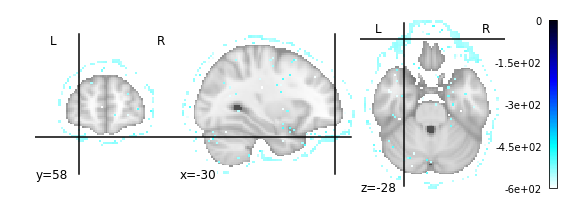

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

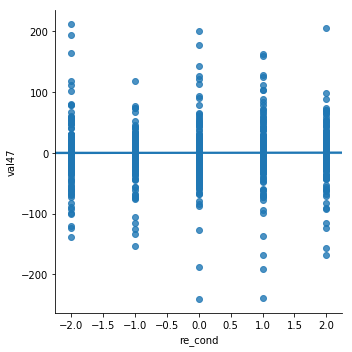

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val47      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  666.6796   
Min. group size:      43          Likelihood:             -12566.4599
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.056    0.514  0.110 0.913 -0.950  1.063
C(re_cond, Poly).Linear     0.255    1.115  0.228 0.819 -1.931  2.440
C(re_cond, Poly).Quadratic -0.063    1.116 -0.057 0.955 -2.250  2.124
C(re_cond, Poly).Cubic     -1.104    1.109 -0.996 0.319 -3.277  1.069
C(re_cond, Poly)^4         -0.323   

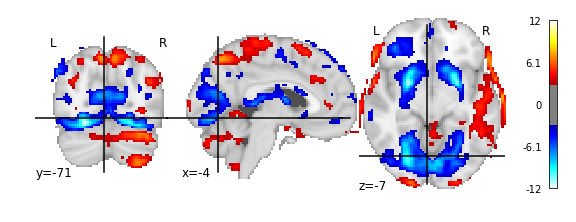

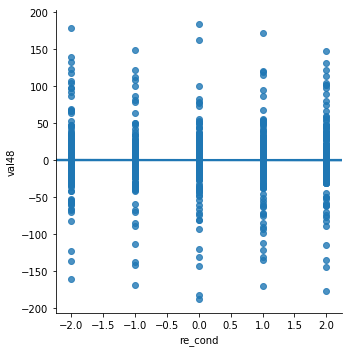

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val48      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  610.2340   
Min. group size:      43          Likelihood:             -12458.7316
Max. group size:      69          Converged:              Yes        
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.028    0.630  0.044 0.965 -1.206  1.262
C(re_cond, Poly).Linear    -0.157    1.067 -0.147 0.883 -2.249  1.935
C(re_cond, Poly).Quadratic  1.523    1.068  1.425 0.154 -0.571  3.617
C(re_cond, Poly).Cubic      0.754    1.062  0.710 0.478 -1.328  2.836
C(re_cond, Poly)^4         -0.094   

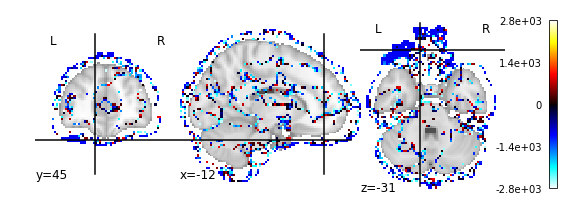

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

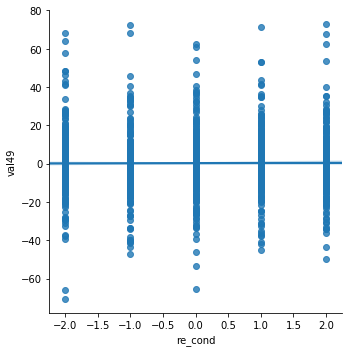

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val49      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  131.0942   
Min. group size:      43          Likelihood:             -10381.1952
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.253    0.227  1.115 0.265 -0.192  0.697
C(re_cond, Poly).Linear     0.189    0.494  0.383 0.702 -0.779  1.158
C(re_cond, Poly).Quadratic  0.642    0.495  1.297 0.195 -0.328  1.611
C(re_cond, Poly).Cubic     -0.318    0.492 -0.646 0.518 -1.281  0.646
C(re_cond, Poly)^4         -0.177   

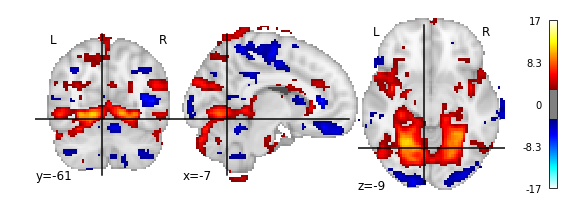

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

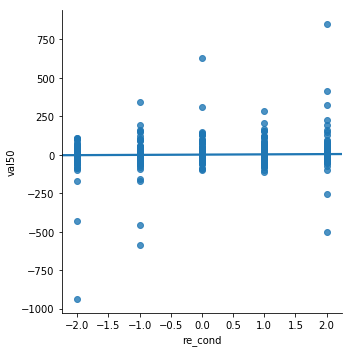

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val50      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  1869.9941  
Min. group size:      43          Likelihood:             -13952.1006
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.926    0.860  1.077 0.281 -0.759  2.611
C(re_cond, Poly).Linear     5.333    1.867  2.857 0.004  1.674  8.991
C(re_cond, Poly).Quadratic -1.350    1.869 -0.723 0.470 -5.012  2.312
C(re_cond, Poly).Cubic     -0.326    1.857 -0.175 0.861 -3.965  3.314
C(re_cond, Poly)^4          2.138   

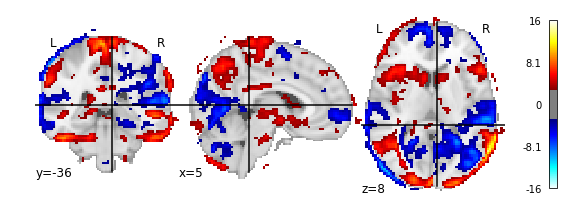

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conver

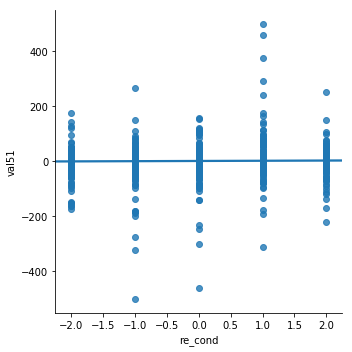

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     val51      
No. Observations:     2692        Method:                 REML       
No. Groups:           46          Scale:                  1400.0009  
Min. group size:      43          Likelihood:             -13563.2815
Max. group size:      69          Converged:              No         
Mean group size:      58.5                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.641    0.745 -0.861 0.389 -2.102  0.819
C(re_cond, Poly).Linear     2.389    1.615  1.479 0.139 -0.776  5.554
C(re_cond, Poly).Quadratic  0.298    1.617  0.184 0.854 -2.871  3.467
C(re_cond, Poly).Cubic     -4.050    1.607 -2.520 0.012 -7.199 -0.900
C(re_cond, Poly)^4         -2.563   

In [7]:
df=res_no_out.loc[res_no_out['Group']==0]
for i in range(1,52):
    dep_val="val%s"%(i)
    print (dep_val)
    plot_stat_map(nil.image.index_img(images,i-1), threshold=3)
    show()
    #for x in range(3):
    #mod=smf.mixedlm("%s~C(re_cond,Poly)"%(dep_val), data=df,groups=df["ID"],eval_env=2)
    mod=smf.mixedlm("%s~C(re_cond,Poly)"%(dep_val), data=df,groups=df["ID"])
    res=mod.fit()
    #sb.barplot(data=df,x='re_cond',y=dep_val,ci=95).set_title("group=%s"%('All'))
    sb.lmplot(x='re_cond',y=dep_val,data=df,units='ID')
    plt.show()
    print(res.summary(title="group=%s"%(dep_val)))
    print(res.tvalues)

In [8]:
val_names=['val%s'%(_) for _ in range(1,52)]
Smodes=pd.DataFrame(np.genfromtxt('second_go_w_contrast.ica/melodic_Smodes'))
Smodes.columns=val_names
Smodes=Smodes.join(group_id)


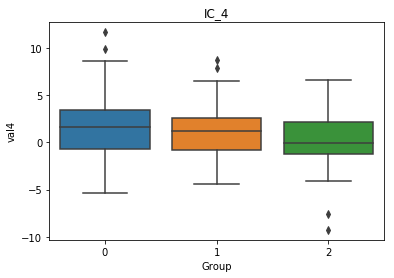

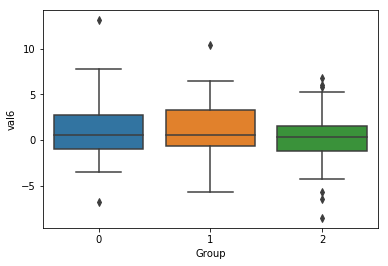

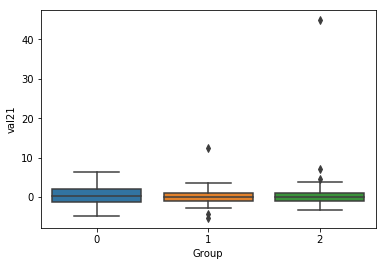

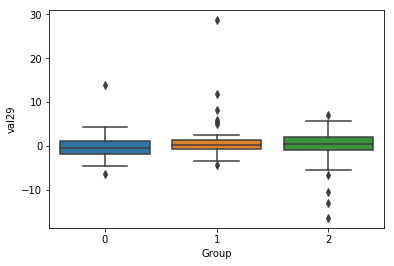

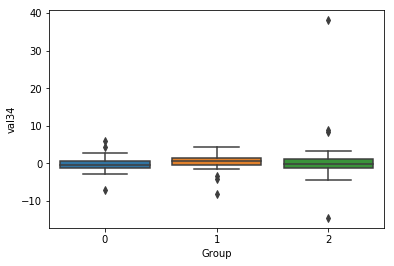

In [9]:
sb.boxplot(x='Group',y='val4',data=Smodes).set_title('IC_4')
plt.show()
sb.boxplot(x='Group',y='val6',data=Smodes)
plt.show()
sb.boxplot(x='Group',y='val21',data=Smodes)
plt.show()
sb.boxplot(x='Group',y='val29',data=Smodes)
plt.show()
sb.boxplot(x='Group',y='val34',data=Smodes)
plt.show()

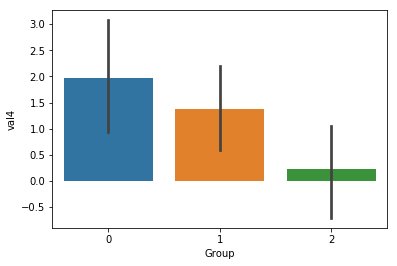

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.5903  -2.1587  0.9781 False 
  0      2    -1.7514  -3.3363 -0.1664  True 
  1      2    -1.1611  -2.7295  0.4073 False 
---------------------------------------------


/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/stats/libqsturng/qsturng_.py:480: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  f += 1./(191.*(v,1e38)[np.isinf(v)])


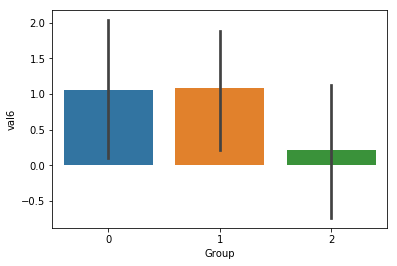

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.0268  -1.5411 1.5947 False 
  0      2    -0.8396  -2.4241 0.7449 False 
  1      2    -0.8664  -2.4343 0.7015 False 
--------------------------------------------


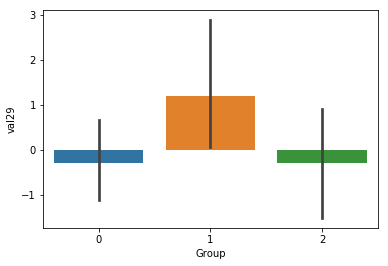

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     1.4911  -0.5817 3.5639 False 
  0      2    -0.0086  -2.1033 2.0861 False 
  1      2    -1.4997  -3.5725 0.5731 False 
--------------------------------------------


In [10]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
sb.barplot(x='Group',y='val4',data=Smodes)
plt.plot()
plt.show()
res=pairwise_tukeyhsd(Smodes['val4'],Smodes['Group'])
print(res)

sb.barplot(x='Group',y='val6',data=Smodes)
plt.plot()
res=pairwise_tukeyhsd(Smodes['val6'],Smodes['Group'])
plt.show()
print(res)

sb.barplot(x='Group',y='val29',data=Smodes)
plt.plot()
res=pairwise_tukeyhsd(Smodes['val29'],Smodes['Group'])
plt.show()
print(res)


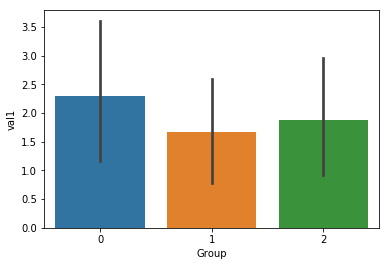

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.6413  -2.4435 1.1608 False 
  0      2    -0.4235  -2.2447 1.3978 False 
  1      2     0.2179  -1.5843  2.02  False 
--------------------------------------------


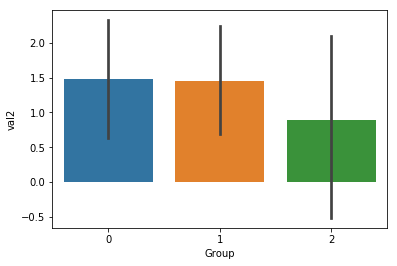

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.0287  -1.7942 1.7369 False 
  0      2    -0.5848   -2.369 1.1995 False 
  1      2    -0.5561  -2.3216 1.2095 False 
--------------------------------------------


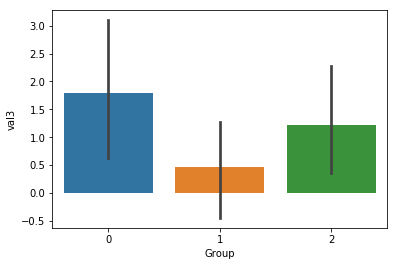

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -1.3265  -3.1312 0.4782 False 
  0      2    -0.5803  -2.4041 1.2436 False 
  1      2     0.7463  -1.0584 2.551  False 
--------------------------------------------


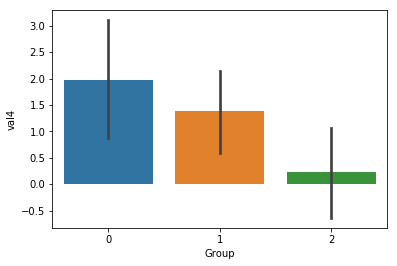

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.5903  -2.1587  0.9781 False 
  0      2    -1.7514  -3.3363 -0.1664  True 
  1      2    -1.1611  -2.7295  0.4073 False 
---------------------------------------------


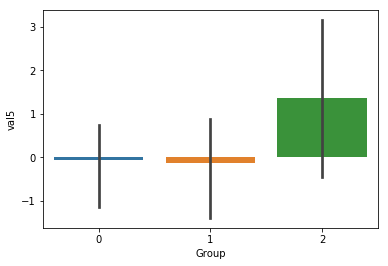

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.0586  -2.3477 2.2305 False 
  0      2     1.4211  -0.8923 3.7344 False 
  1      2     1.4797  -0.8095 3.7688 False 
--------------------------------------------


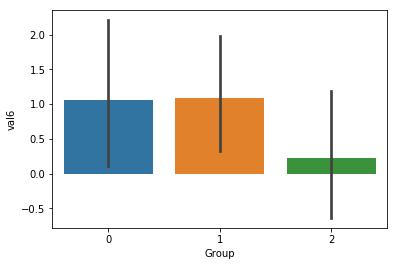

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.0268  -1.5411 1.5947 False 
  0      2    -0.8396  -2.4241 0.7449 False 
  1      2    -0.8664  -2.4343 0.7015 False 
--------------------------------------------


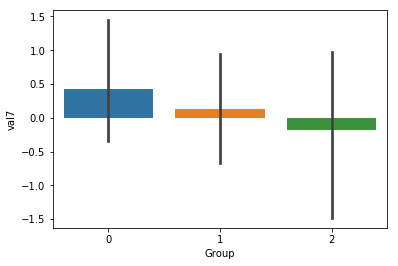

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.2986   -2.051 1.4537 False 
  0      2    -0.6082  -2.3791 1.1627 False 
  1      2    -0.3096  -2.0619 1.4428 False 
--------------------------------------------


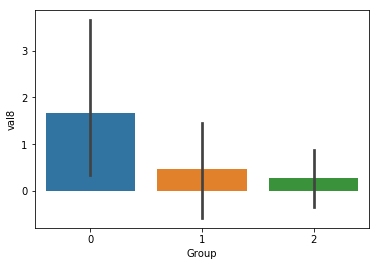

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     -1.204  -3.1786 0.7705 False 
  0      2    -1.3906   -3.386 0.6049 False 
  1      2    -0.1865  -2.1611 1.788  False 
--------------------------------------------


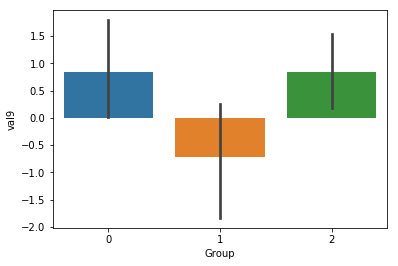

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -1.5569  -3.1342 0.0203 False 
  0      2    -0.0019  -1.5959 1.592  False 
  1      2     1.555   -0.0223 3.1323 False 
--------------------------------------------


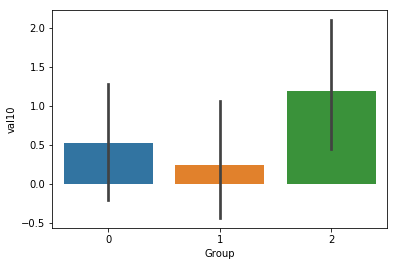

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.2787  -1.6107 1.0533 False 
  0      2     0.6693  -0.6768 2.0154 False 
  1      2     0.948    -0.384  2.28  False 
--------------------------------------------


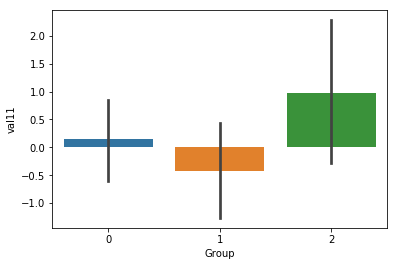

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.5715  -2.2556 1.1126 False 
  0      2     0.827   -0.8749 2.5289 False 
  1      2     1.3985  -0.2856 3.0826 False 
--------------------------------------------


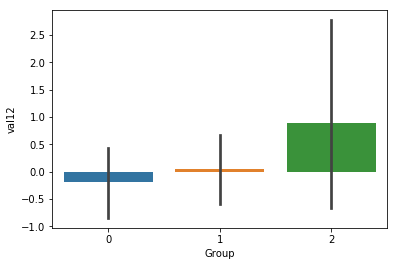

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.2444   -1.659 2.1477 False 
  0      2     1.0808  -0.8427 3.0043 False 
  1      2     0.8364  -1.0669 2.7398 False 
--------------------------------------------


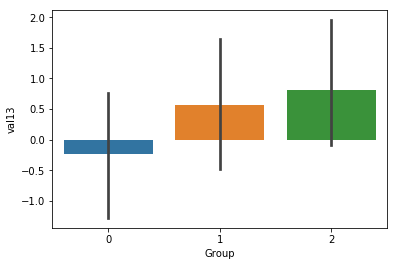

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.7994  -0.9889 2.5876 False 
  0      2     1.0402  -0.7669 2.8474 False 
  1      2     0.2409  -1.5473 2.0291 False 
--------------------------------------------


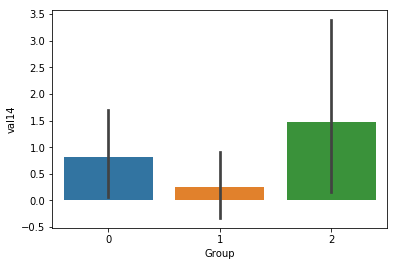

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     -0.557  -2.4862 1.3721 False 
  0      2     0.6652  -1.2844 2.6147 False 
  1      2     1.2222  -0.7069 3.1513 False 
--------------------------------------------


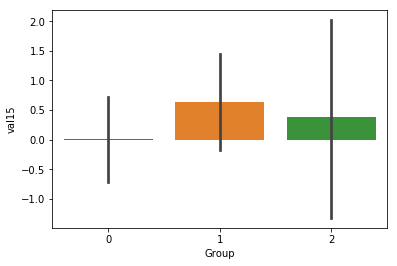

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.6152  -1.3546 2.585  False 
  0      2     0.3656  -1.6251 2.3562 False 
  1      2    -0.2496  -2.2194 1.7202 False 
--------------------------------------------


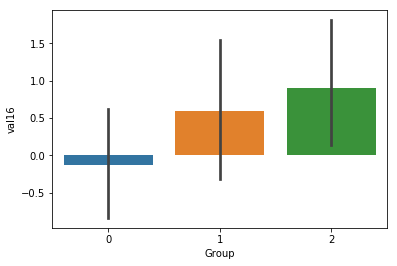

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.7203  -0.6891 2.1297 False 
  0      2     1.0302  -0.3941 2.4545 False 
  1      2     0.3099  -1.0995 1.7193 False 
--------------------------------------------


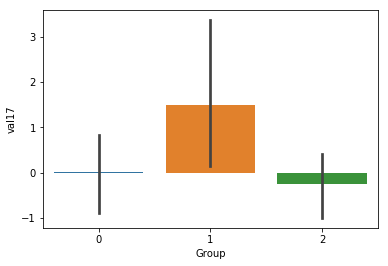

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     1.4815  -0.4152 3.3782 False 
  0      2    -0.2711  -2.1879 1.6457 False 
  1      2    -1.7526  -3.6493 0.1441 False 
--------------------------------------------


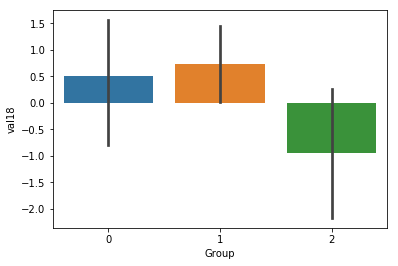

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.2266  -1.5999 2.0531 False 
  0      2    -1.4425  -3.2883 0.4033 False 
  1      2    -1.6691  -3.4956 0.1574 False 
--------------------------------------------


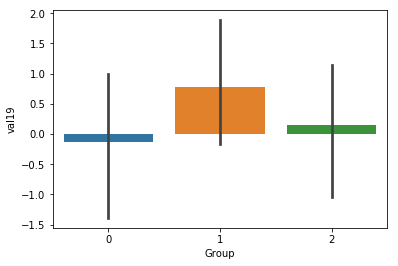

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.9176  -0.9716 2.8069 False 
  0      2     0.2826  -1.6266 2.1918 False 
  1      2     -0.635  -2.5243 1.2542 False 
--------------------------------------------


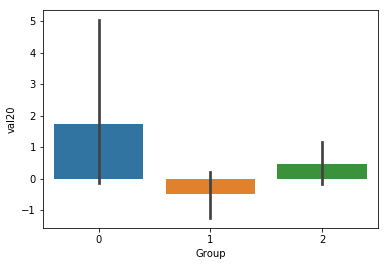

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -2.2236  -5.1813 0.734  False 
  0      2    -1.2884  -4.2774 1.7005 False 
  1      2     0.9352  -2.0225 3.8929 False 
--------------------------------------------


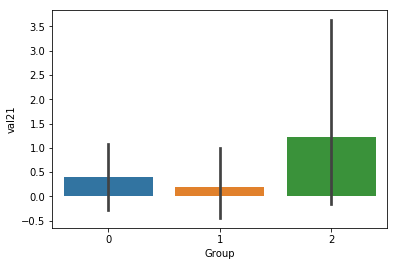

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.2091  -2.3776 1.9593 False 
  0      2     0.8293  -1.3621 3.0208 False 
  1      2     1.0385   -1.13  3.207  False 
--------------------------------------------


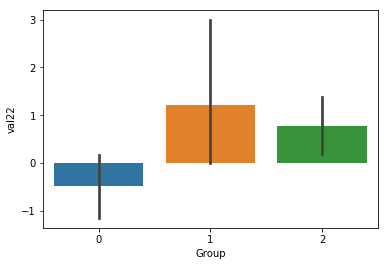

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     1.6905  -0.0557 3.4367 False 
  0      2     1.2498  -0.5149 3.0145 False 
  1      2    -0.4407  -2.1869 1.3056 False 
--------------------------------------------


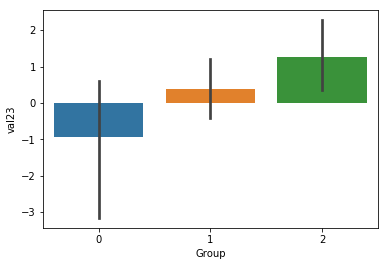

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     1.3409  -0.9527 3.6344 False 
  0      2     2.2196  -0.0982 4.5374 False 
  1      2     0.8787  -1.4148 3.1722 False 
--------------------------------------------


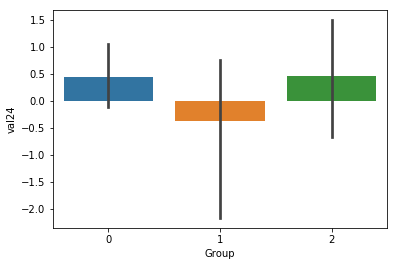

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     -0.818  -2.6824 1.0463 False 
  0      2     0.0197  -1.8644 1.9038 False 
  1      2     0.8377  -1.0267 2.7021 False 
--------------------------------------------


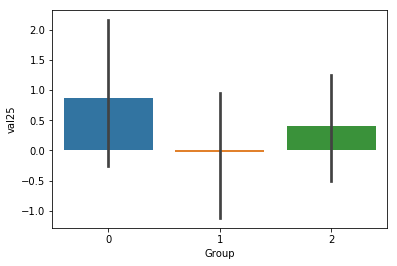

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.8792  -2.7096 0.9513 False 
  0      2     -0.461  -2.3108 1.3888 False 
  1      2     0.4181  -1.4123 2.2486 False 
--------------------------------------------


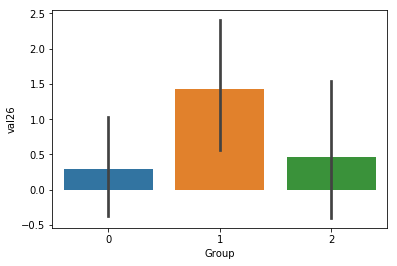

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     1.1374  -0.3982 2.6731 False 
  0      2     0.1717  -1.3802 1.7236 False 
  1      2    -0.9657  -2.5013  0.57  False 
--------------------------------------------


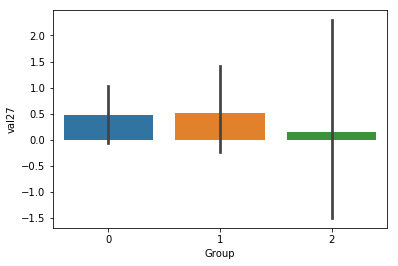

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.0433  -2.1299 2.2165 False 
  0      2    -0.3317  -2.5279 1.8645 False 
  1      2     -0.375  -2.5482 1.7982 False 
--------------------------------------------


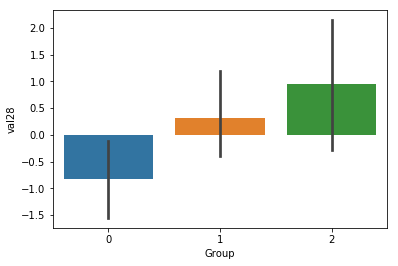

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  0      1     1.1494  -0.425 2.7238 False 
  0      2     1.7708  0.1797 3.3618  True 
  1      2     0.6214  -0.953 2.1957 False 
-------------------------------------------


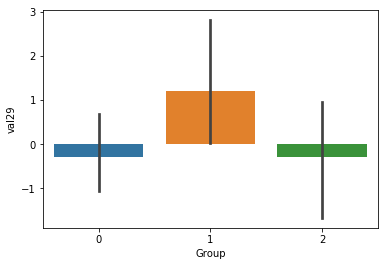

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     1.4911  -0.5817 3.5639 False 
  0      2    -0.0086  -2.1033 2.0861 False 
  1      2    -1.4997  -3.5725 0.5731 False 
--------------------------------------------


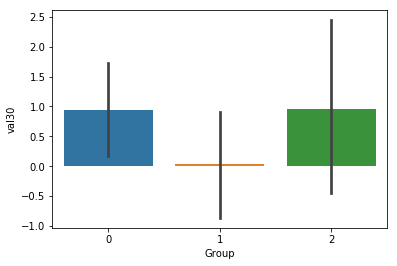

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     -0.89   -2.7531 0.9732 False 
  0      2     0.0139   -1.869 1.8967 False 
  1      2     0.9038  -0.9593 2.767  False 
--------------------------------------------


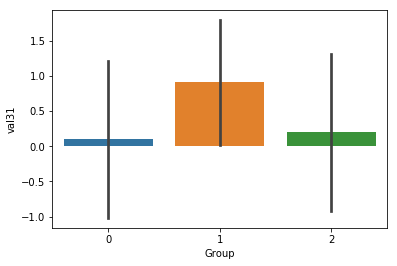

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.8105  -0.9457 2.5667 False 
  0      2     0.099   -1.6757 1.8738 False 
  1      2    -0.7115  -2.4676 1.0447 False 
--------------------------------------------


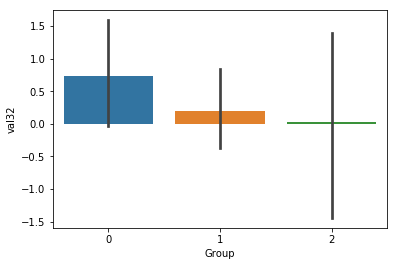

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.5309  -2.2896 1.2278 False 
  0      2    -0.7052  -2.4825 1.0721 False 
  1      2    -0.1743  -1.9329 1.5844 False 
--------------------------------------------


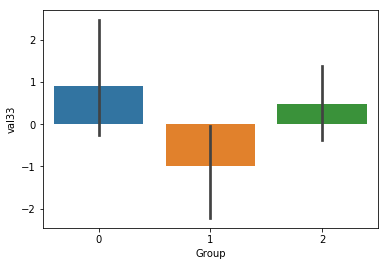

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -1.8814  -3.8909 0.1281 False 
  0      2    -0.4201  -2.4508 1.6107 False 
  1      2     1.4613  -0.5482 3.4708 False 
--------------------------------------------


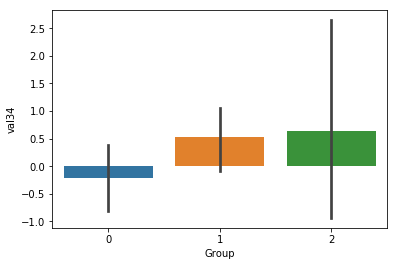

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.7403  -1.2697 2.7502 False 
  0      2     0.8505  -1.1807 2.8817 False 
  1      2     0.1102  -1.8997 2.1202 False 
--------------------------------------------


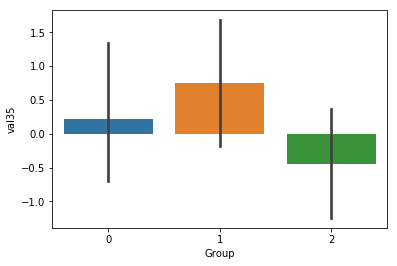

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.5352  -1.1211 2.1915 False 
  0      2    -0.6611  -2.3349 1.0127 False 
  1      2    -1.1963  -2.8526  0.46  False 
--------------------------------------------


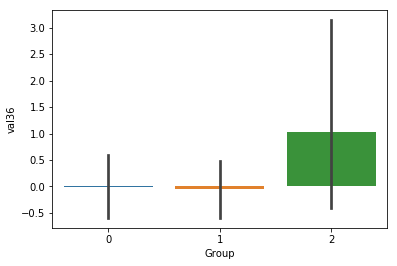

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.0539  -2.1763 2.0684 False 
  0      2     1.0345  -1.1103 3.1792 False 
  1      2     1.0884  -1.0339 3.2107 False 
--------------------------------------------


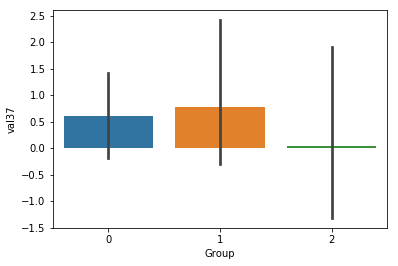

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.1829  -2.0961 2.4619 False 
  0      2    -0.5541  -2.8572 1.749  False 
  1      2     -0.737   -3.016 1.5419 False 
--------------------------------------------


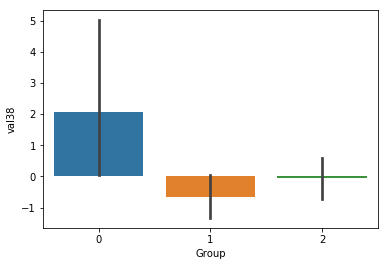

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     -2.712  -5.4979 0.0738 False 
  0      2    -2.1188  -4.9341 0.6965 False 
  1      2     0.5932  -2.1926 3.3791 False 
--------------------------------------------


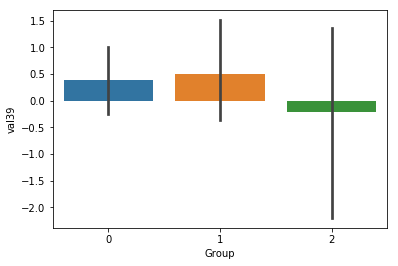

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.1005  -2.0103 2.2113 False 
  0      2    -0.6122  -2.7454 1.521  False 
  1      2    -0.7127  -2.8235 1.3981 False 
--------------------------------------------


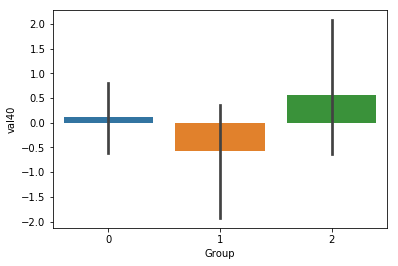

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.6868  -2.6102 1.2366 False 
  0      2     0.4331  -1.5106 2.3768 False 
  1      2     1.1199  -0.8035 3.0433 False 
--------------------------------------------


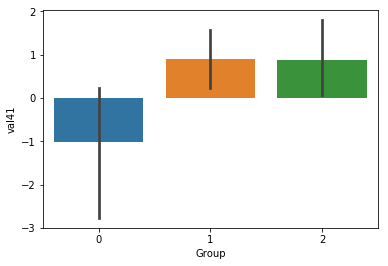

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     1.8991   0.0325 3.7658  True 
  0      2     1.8846  -0.0017 3.771  False 
  1      2    -0.0145  -1.8811 1.8521 False 
--------------------------------------------


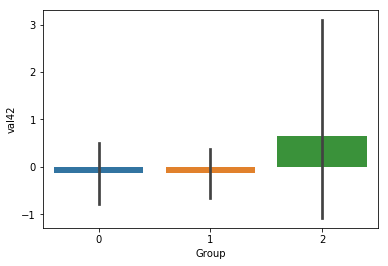

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.0015  -2.2331 2.2301 False 
  0      2     0.7809  -1.4744 3.0361 False 
  1      2     0.7823  -1.4493 3.014  False 
--------------------------------------------


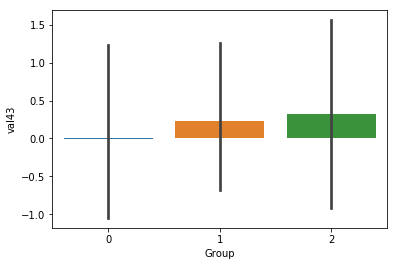

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.2314  -1.6551 2.1179 False 
  0      2     0.3301  -1.5764 2.2365 False 
  1      2     0.0986  -1.7879 1.9851 False 
--------------------------------------------


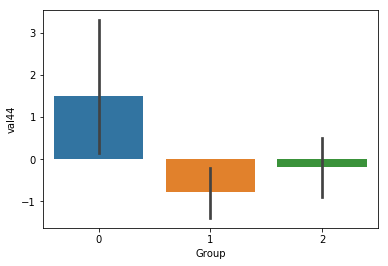

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -2.2821  -4.1507 -0.4135  True 
  0      2    -1.6717  -3.5601  0.2167 False 
  1      2     0.6104  -1.2583  2.479  False 
---------------------------------------------


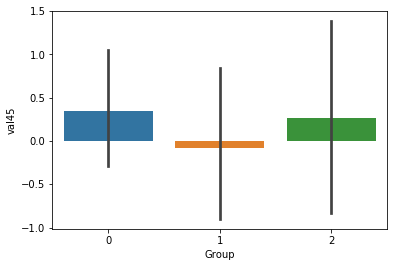

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.4179  -2.0106 1.1748 False 
  0      2    -0.0766  -1.6861 1.533  False 
  1      2     0.3413  -1.2513 1.934  False 
--------------------------------------------


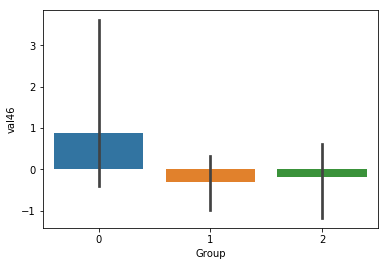

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -1.1821   -3.374 1.0097 False 
  0      2    -1.0576  -3.2726 1.1574 False 
  1      2     0.1245  -2.0673 2.3164 False 
--------------------------------------------


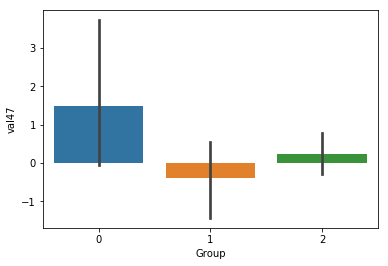

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -1.8779  -4.2207 0.4648 False 
  0      2    -1.2446  -3.6122 1.123  False 
  1      2     0.6333  -1.7094 2.9761 False 
--------------------------------------------


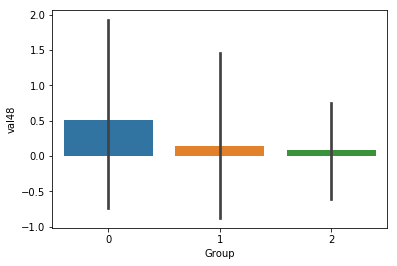

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.3567  -2.2327 1.5194 False 
  0      2     -0.417  -2.3129 1.4788 False 
  1      2    -0.0604  -1.9364 1.8157 False 
--------------------------------------------


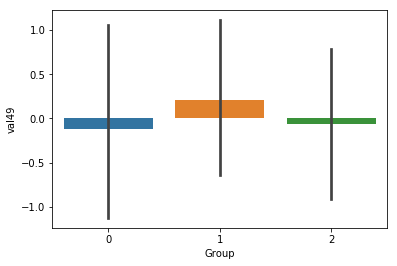

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.332   -1.2853 1.9493 False 
  0      2     0.0649  -1.5695 1.6993 False 
  1      2    -0.2671  -1.8844 1.3502 False 
--------------------------------------------


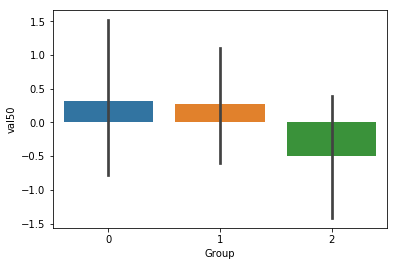

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     -0.039  -1.7252 1.6473 False 
  0      2    -0.8211  -2.5252 0.883  False 
  1      2    -0.7821  -2.4684 0.9041 False 
--------------------------------------------


In [11]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for i in range(1,51):
    dv='val%s'%(i)
    sb.barplot(x='Group',y=dv,data=Smodes)
    plt.plot()
    plt.show()
    res=pairwise_tukeyhsd(Smodes[dv],Smodes['Group'])
    print(res)